In [6]:
pip install opencv-python

     |████████████████████████████████| 49.1MB 7.5MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [2]:
from tqdm import tqdm
import cv2
import numpy as np
import os

In [3]:
REBUILD_DATA = False
class DogsVSCats():
    IMG_SIZE = 50
    CATS = 'PetImages/Cat'
    DOGS = 'PetImages/Dog'
    LABELS = {CATS: 0,DOGS: 1}
    training_data = []
    catcount = 0
    dogcount = 0
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    print(path)
                    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img),np.eye(2)[self.LABELS[label]]])
                    print(label)
                    if label == self.CATS:
                        self.catcount+=1
                    elif label == self.DOGS:
                        self.dogcount+=1
                except Exception as e:
                        pass
        np.random.shuffle(self.training_data)
        np.save("training_data.npy",self.training_data)
        print('Cats:',self.catcount)
        print('DogS:',self.dogcount)
                    
                
if REBUILD_DATA:
    dogvscats = DogsVSCats()
    dogvscats.make_training_data()

In [4]:
training_data = np.load("training_data.npy",allow_pickle = True)

In [48]:
training_data[2]

array([array([[249, 250, 250, ..., 217, 205, 209],
       [249, 249, 250, ..., 234, 230, 221],
       [249, 250, 136, ..., 242, 237, 244],
       ...,
       [213, 173,  23, ..., 176, 216, 205],
       [224, 157,  43, ..., 192, 187, 195],
       [207, 134,  47, ..., 196, 199, 195]], dtype=uint8),
       array([1., 0.])], dtype=object)

In [9]:
import torch.optim as optim

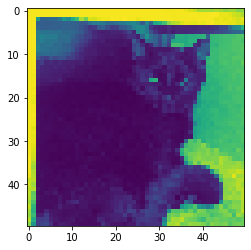

In [6]:
plt.imshow(training_data[2][0],)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear,512)
        
        self.fc2 = nn.Linear(512,2)
        
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1,self._to_linear)# difference between -1, 1 ? 
        x =F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x,dim = 1)
    
net =Net()           

In [10]:

optimiser = optim.Adam(net.parameters(),lr =0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)

In [11]:
train_X = X[:-val_size]
train_y = y[:-val_size]
test_X = X[-val_size:]
test_y = y[-val_size:]
print(len(test_y),len(test_X))

2494 2494


In [68]:
def train(net):
    BATCH_SIZE = 100
    EPOCHS = 1
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]


            acc, loss = fwd_pass(batch_X, batch_y, train=True)

            print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")


In [69]:
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i])
            net_out = net(test_X[i].view(-1,1,50,50))[0]
            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct+=1
            else:
                plt.imshow(test_X[i],cmap="gray")
                print(net_out)
                plt.show()
            total+=1
    print('Accuracy:',round(correct/total,3))

In [14]:
torch.cuda.is_available()

False

In [15]:
EPOCHS = 5

In [74]:
train(net)


  0%|          | 1/225 [00:00<01:15,  2.98it/s]

Acc: 0.91  Loss: 0.067



  1%|          | 2/225 [00:00<01:14,  3.01it/s]

Acc: 0.94  Loss: 0.0451



  1%|▏         | 3/225 [00:01<01:15,  2.94it/s]

Acc: 0.95  Loss: 0.0375



  2%|▏         | 4/225 [00:01<01:15,  2.93it/s]

Acc: 0.97  Loss: 0.0237



  2%|▏         | 5/225 [00:01<01:15,  2.92it/s]

Acc: 0.91  Loss: 0.0542



  3%|▎         | 6/225 [00:02<01:15,  2.90it/s]

Acc: 0.98  Loss: 0.0268



  3%|▎         | 7/225 [00:02<01:15,  2.89it/s]

Acc: 0.96  Loss: 0.0368



  4%|▎         | 8/225 [00:02<01:15,  2.86it/s]

Acc: 0.92  Loss: 0.0591



  4%|▍         | 9/225 [00:03<01:15,  2.84it/s]

Acc: 0.98  Loss: 0.0247



  4%|▍         | 10/225 [00:03<01:14,  2.89it/s]

Acc: 0.93  Loss: 0.0612



  5%|▍         | 11/225 [00:03<01:14,  2.86it/s]

Acc: 0.99  Loss: 0.0189



  5%|▌         | 12/225 [00:04<01:13,  2.91it/s]

Acc: 0.98  Loss: 0.0193



  6%|▌         | 13/225 [00:04<01:12,  2.91it/s]

Acc: 0.98  Loss: 0.0191



  6%|▌         | 14/225 [00:04<01:12,  2.93it/s]

Acc: 0.95  Loss: 0.0398



  7%|▋         | 15/225 [00:05<01:12,  2.88it/s]

Acc: 0.97  Loss: 0.0223



  7%|▋         | 16/225 [00:05<01:12,  2.89it/s]

Acc: 0.94  Loss: 0.0447



  8%|▊         | 17/225 [00:05<01:12,  2.87it/s]

Acc: 0.95  Loss: 0.035



  8%|▊         | 18/225 [00:06<01:12,  2.86it/s]

Acc: 0.95  Loss: 0.0281



  8%|▊         | 19/225 [00:06<01:12,  2.83it/s]

Acc: 0.96  Loss: 0.0282



  9%|▉         | 20/225 [00:06<01:13,  2.79it/s]

Acc: 0.97  Loss: 0.0336



  9%|▉         | 21/225 [00:07<01:13,  2.76it/s]

Acc: 0.98  Loss: 0.0202



 10%|▉         | 22/225 [00:07<01:12,  2.82it/s]

Acc: 0.92  Loss: 0.043



 10%|█         | 23/225 [00:08<01:12,  2.80it/s]

Acc: 0.96  Loss: 0.0265



 11%|█         | 24/225 [00:08<01:09,  2.88it/s]

Acc: 0.95  Loss: 0.0404



 11%|█         | 25/225 [00:08<01:08,  2.93it/s]

Acc: 0.96  Loss: 0.0259



 12%|█▏        | 26/225 [00:09<01:08,  2.92it/s]

Acc: 0.96  Loss: 0.0382



 12%|█▏        | 27/225 [00:09<01:08,  2.88it/s]

Acc: 0.96  Loss: 0.0309



 12%|█▏        | 28/225 [00:09<01:08,  2.86it/s]

Acc: 0.97  Loss: 0.0326



 13%|█▎        | 29/225 [00:10<01:08,  2.85it/s]

Acc: 0.96  Loss: 0.0338



 13%|█▎        | 30/225 [00:10<01:08,  2.85it/s]

Acc: 0.94  Loss: 0.0364



 14%|█▍        | 31/225 [00:10<01:08,  2.85it/s]

Acc: 0.98  Loss: 0.0297



 14%|█▍        | 32/225 [00:11<01:07,  2.84it/s]

Acc: 0.97  Loss: 0.0199



 15%|█▍        | 33/225 [00:11<01:08,  2.82it/s]

Acc: 0.97  Loss: 0.0221



 15%|█▌        | 34/225 [00:11<01:07,  2.84it/s]

Acc: 0.98  Loss: 0.0215



 16%|█▌        | 35/225 [00:12<01:06,  2.86it/s]

Acc: 0.99  Loss: 0.0158



 16%|█▌        | 36/225 [00:12<01:07,  2.81it/s]

Acc: 0.99  Loss: 0.0149



 16%|█▋        | 37/225 [00:12<01:06,  2.82it/s]

Acc: 0.98  Loss: 0.0269



 17%|█▋        | 38/225 [00:13<01:06,  2.83it/s]

Acc: 0.98  Loss: 0.028



 17%|█▋        | 39/225 [00:13<01:05,  2.83it/s]

Acc: 0.97  Loss: 0.027



 18%|█▊        | 40/225 [00:13<01:04,  2.85it/s]

Acc: 0.95  Loss: 0.0469



 18%|█▊        | 41/225 [00:14<01:05,  2.82it/s]

Acc: 0.97  Loss: 0.0181



 19%|█▊        | 42/225 [00:14<01:05,  2.80it/s]

Acc: 0.93  Loss: 0.0526



 19%|█▉        | 43/225 [00:15<01:04,  2.80it/s]

Acc: 1.0  Loss: 0.0136



 20%|█▉        | 44/225 [00:15<01:05,  2.75it/s]

Acc: 1.0  Loss: 0.0081



 20%|██        | 45/225 [00:15<01:05,  2.76it/s]

Acc: 0.94  Loss: 0.0455



 20%|██        | 46/225 [00:16<01:03,  2.80it/s]

Acc: 0.97  Loss: 0.0219



 21%|██        | 47/225 [00:16<01:02,  2.83it/s]

Acc: 0.97  Loss: 0.0363



 21%|██▏       | 48/225 [00:16<01:02,  2.85it/s]

Acc: 1.0  Loss: 0.003



 22%|██▏       | 49/225 [00:17<01:00,  2.89it/s]

Acc: 0.99  Loss: 0.0092



 22%|██▏       | 50/225 [00:17<00:59,  2.93it/s]

Acc: 0.95  Loss: 0.0387



 23%|██▎       | 51/225 [00:17<00:58,  2.96it/s]

Acc: 0.96  Loss: 0.0365



 23%|██▎       | 52/225 [00:18<00:57,  2.99it/s]

Acc: 0.96  Loss: 0.0343



 24%|██▎       | 53/225 [00:18<00:57,  3.00it/s]

Acc: 0.97  Loss: 0.0307



 24%|██▍       | 54/225 [00:18<00:56,  3.02it/s]

Acc: 0.99  Loss: 0.0109



 24%|██▍       | 55/225 [00:19<00:55,  3.04it/s]

Acc: 0.99  Loss: 0.0104



 25%|██▍       | 56/225 [00:19<00:55,  3.04it/s]

Acc: 0.94  Loss: 0.0473



 25%|██▌       | 57/225 [00:19<00:55,  3.05it/s]

Acc: 0.95  Loss: 0.0381



 26%|██▌       | 58/225 [00:20<00:54,  3.05it/s]

Acc: 0.97  Loss: 0.0202



 26%|██▌       | 59/225 [00:20<00:54,  3.03it/s]

Acc: 0.96  Loss: 0.0403



 27%|██▋       | 60/225 [00:20<00:54,  3.05it/s]

Acc: 0.98  Loss: 0.0268



 27%|██▋       | 61/225 [00:21<00:54,  3.02it/s]

Acc: 0.96  Loss: 0.0346



 28%|██▊       | 62/225 [00:21<00:54,  2.97it/s]

Acc: 0.99  Loss: 0.0075



 28%|██▊       | 63/225 [00:21<00:54,  2.95it/s]

Acc: 0.97  Loss: 0.0252



 28%|██▊       | 64/225 [00:22<00:55,  2.93it/s]

Acc: 0.99  Loss: 0.0134



 29%|██▉       | 65/225 [00:22<00:55,  2.90it/s]

Acc: 0.94  Loss: 0.0546



 29%|██▉       | 66/225 [00:22<00:54,  2.93it/s]

Acc: 0.95  Loss: 0.0273



 30%|██▉       | 67/225 [00:23<00:53,  2.96it/s]

Acc: 0.97  Loss: 0.0132



 30%|███       | 68/225 [00:23<00:52,  2.99it/s]

Acc: 0.94  Loss: 0.0528



 31%|███       | 69/225 [00:23<00:52,  3.00it/s]

Acc: 0.94  Loss: 0.0389



 31%|███       | 70/225 [00:24<00:51,  3.00it/s]

Acc: 0.97  Loss: 0.0228



 32%|███▏      | 71/225 [00:24<00:50,  3.03it/s]

Acc: 0.95  Loss: 0.0354



 32%|███▏      | 72/225 [00:24<00:50,  3.03it/s]

Acc: 0.94  Loss: 0.0471



 32%|███▏      | 73/225 [00:25<00:50,  3.03it/s]

Acc: 0.96  Loss: 0.0277



 33%|███▎      | 74/225 [00:25<00:50,  2.99it/s]

Acc: 0.96  Loss: 0.0277



 33%|███▎      | 75/225 [00:25<00:50,  2.98it/s]

Acc: 0.96  Loss: 0.0362



 34%|███▍      | 76/225 [00:26<00:49,  2.98it/s]

Acc: 0.95  Loss: 0.0333



 34%|███▍      | 77/225 [00:26<00:49,  2.98it/s]

Acc: 0.96  Loss: 0.0306



 35%|███▍      | 78/225 [00:26<00:50,  2.94it/s]

Acc: 0.97  Loss: 0.022



 35%|███▌      | 79/225 [00:27<00:49,  2.95it/s]

Acc: 0.96  Loss: 0.0363



 36%|███▌      | 80/225 [00:27<00:50,  2.89it/s]

Acc: 0.97  Loss: 0.0239



 36%|███▌      | 81/225 [00:27<00:49,  2.91it/s]

Acc: 0.93  Loss: 0.0519



 36%|███▋      | 82/225 [00:28<00:48,  2.93it/s]

Acc: 0.96  Loss: 0.0455



 37%|███▋      | 83/225 [00:28<00:48,  2.94it/s]

Acc: 0.97  Loss: 0.0322



 37%|███▋      | 84/225 [00:28<00:47,  2.95it/s]

Acc: 0.93  Loss: 0.045



 38%|███▊      | 85/225 [00:29<00:47,  2.98it/s]

Acc: 0.94  Loss: 0.0396



 38%|███▊      | 86/225 [00:29<00:46,  3.00it/s]

Acc: 0.97  Loss: 0.0273



 39%|███▊      | 87/225 [00:29<00:46,  2.98it/s]

Acc: 0.96  Loss: 0.0422



 39%|███▉      | 88/225 [00:30<00:45,  2.98it/s]

Acc: 0.97  Loss: 0.0173



 40%|███▉      | 89/225 [00:30<00:45,  2.99it/s]

Acc: 0.92  Loss: 0.0555



 40%|████      | 90/225 [00:30<00:44,  3.01it/s]

Acc: 0.96  Loss: 0.0243



 40%|████      | 91/225 [00:31<00:44,  3.00it/s]

Acc: 0.88  Loss: 0.097



 41%|████      | 92/225 [00:31<00:44,  2.97it/s]

Acc: 0.93  Loss: 0.0496



 41%|████▏     | 93/225 [00:31<00:44,  2.96it/s]

Acc: 0.94  Loss: 0.0519



 42%|████▏     | 94/225 [00:32<00:44,  2.97it/s]

Acc: 0.94  Loss: 0.0448



 42%|████▏     | 95/225 [00:32<00:43,  2.99it/s]

Acc: 0.94  Loss: 0.0495



 43%|████▎     | 96/225 [00:32<00:43,  2.99it/s]

Acc: 0.98  Loss: 0.0192



 43%|████▎     | 97/225 [00:33<00:42,  2.99it/s]

Acc: 0.95  Loss: 0.0355



 44%|████▎     | 98/225 [00:33<00:42,  3.01it/s]

Acc: 0.97  Loss: 0.0342



 44%|████▍     | 99/225 [00:33<00:42,  3.00it/s]

Acc: 0.96  Loss: 0.0275



 44%|████▍     | 100/225 [00:34<00:41,  3.00it/s]

Acc: 0.92  Loss: 0.0622



 45%|████▍     | 101/225 [00:34<00:41,  3.00it/s]

Acc: 0.96  Loss: 0.0272



 45%|████▌     | 102/225 [00:34<00:41,  2.98it/s]

Acc: 0.93  Loss: 0.0559



 46%|████▌     | 103/225 [00:35<00:41,  2.97it/s]

Acc: 0.94  Loss: 0.0402



 46%|████▌     | 104/225 [00:35<00:41,  2.92it/s]

Acc: 0.95  Loss: 0.0352



 47%|████▋     | 105/225 [00:35<00:41,  2.92it/s]

Acc: 0.97  Loss: 0.0305



 47%|████▋     | 106/225 [00:36<00:40,  2.93it/s]

Acc: 0.93  Loss: 0.0425



 48%|████▊     | 107/225 [00:36<00:40,  2.94it/s]

Acc: 0.94  Loss: 0.0458



 48%|████▊     | 108/225 [00:36<00:40,  2.92it/s]

Acc: 0.92  Loss: 0.0535



 48%|████▊     | 109/225 [00:37<00:39,  2.93it/s]

Acc: 0.95  Loss: 0.0443



 49%|████▉     | 110/225 [00:37<00:39,  2.94it/s]

Acc: 0.97  Loss: 0.019



 49%|████▉     | 111/225 [00:37<00:38,  2.93it/s]

Acc: 0.97  Loss: 0.0273



 50%|████▉     | 112/225 [00:38<00:38,  2.95it/s]

Acc: 0.99  Loss: 0.011



 50%|█████     | 113/225 [00:38<00:38,  2.93it/s]

Acc: 0.95  Loss: 0.0385



 51%|█████     | 114/225 [00:39<00:37,  2.95it/s]

Acc: 0.96  Loss: 0.0353



 51%|█████     | 115/225 [00:39<00:37,  2.96it/s]

Acc: 0.93  Loss: 0.049



 52%|█████▏    | 116/225 [00:39<00:36,  2.96it/s]

Acc: 0.95  Loss: 0.0447



 52%|█████▏    | 117/225 [00:40<00:36,  2.96it/s]

Acc: 0.96  Loss: 0.0307



 52%|█████▏    | 118/225 [00:40<00:36,  2.97it/s]

Acc: 0.95  Loss: 0.0261



 53%|█████▎    | 119/225 [00:40<00:35,  2.97it/s]

Acc: 0.98  Loss: 0.0182



 53%|█████▎    | 120/225 [00:41<00:35,  2.95it/s]

Acc: 0.92  Loss: 0.0592



 54%|█████▍    | 121/225 [00:41<00:35,  2.96it/s]

Acc: 0.98  Loss: 0.0227



 54%|█████▍    | 122/225 [00:41<00:35,  2.92it/s]

Acc: 0.96  Loss: 0.0221



 55%|█████▍    | 123/225 [00:42<00:35,  2.88it/s]

Acc: 0.94  Loss: 0.0434



 55%|█████▌    | 124/225 [00:42<00:34,  2.90it/s]

Acc: 0.94  Loss: 0.0598



 56%|█████▌    | 125/225 [00:42<00:34,  2.88it/s]

Acc: 0.98  Loss: 0.0229



 56%|█████▌    | 126/225 [00:43<00:34,  2.90it/s]

Acc: 0.97  Loss: 0.0205



 56%|█████▋    | 127/225 [00:43<00:33,  2.92it/s]

Acc: 0.98  Loss: 0.0192



 57%|█████▋    | 128/225 [00:43<00:32,  2.95it/s]

Acc: 0.96  Loss: 0.0343



 57%|█████▋    | 129/225 [00:44<00:32,  2.95it/s]

Acc: 0.97  Loss: 0.0278



 58%|█████▊    | 130/225 [00:44<00:32,  2.93it/s]

Acc: 0.94  Loss: 0.0498



 58%|█████▊    | 131/225 [00:44<00:32,  2.94it/s]

Acc: 0.95  Loss: 0.0386



 59%|█████▊    | 132/225 [00:45<00:31,  2.93it/s]

Acc: 0.94  Loss: 0.0624



 59%|█████▉    | 133/225 [00:45<00:31,  2.95it/s]

Acc: 0.93  Loss: 0.0559



 60%|█████▉    | 134/225 [00:45<00:30,  2.95it/s]

Acc: 0.98  Loss: 0.0147



 60%|██████    | 135/225 [00:46<00:30,  2.96it/s]

Acc: 0.97  Loss: 0.0346



 60%|██████    | 136/225 [00:46<00:30,  2.93it/s]

Acc: 0.95  Loss: 0.0289



 61%|██████    | 137/225 [00:46<00:30,  2.91it/s]

Acc: 0.98  Loss: 0.0199



 61%|██████▏   | 138/225 [00:47<00:29,  2.92it/s]

Acc: 0.99  Loss: 0.0137



 62%|██████▏   | 139/225 [00:47<00:29,  2.94it/s]

Acc: 0.98  Loss: 0.0192



 62%|██████▏   | 140/225 [00:47<00:28,  2.94it/s]

Acc: 0.96  Loss: 0.0336



 63%|██████▎   | 141/225 [00:48<00:28,  2.93it/s]

Acc: 0.95  Loss: 0.0401



 63%|██████▎   | 142/225 [00:48<00:28,  2.93it/s]

Acc: 0.93  Loss: 0.0613



 64%|██████▎   | 143/225 [00:48<00:28,  2.91it/s]

Acc: 0.93  Loss: 0.0514



 64%|██████▍   | 144/225 [00:49<00:27,  2.92it/s]

Acc: 0.97  Loss: 0.0125



 64%|██████▍   | 145/225 [00:49<00:27,  2.92it/s]

Acc: 0.96  Loss: 0.0361



 65%|██████▍   | 146/225 [00:49<00:27,  2.90it/s]

Acc: 0.99  Loss: 0.0098



 65%|██████▌   | 147/225 [00:50<00:26,  2.92it/s]

Acc: 0.95  Loss: 0.035



 66%|██████▌   | 148/225 [00:50<00:26,  2.91it/s]

Acc: 0.95  Loss: 0.0311



 66%|██████▌   | 149/225 [00:50<00:26,  2.91it/s]

Acc: 0.96  Loss: 0.034



 67%|██████▋   | 150/225 [00:51<00:25,  2.91it/s]

Acc: 0.94  Loss: 0.0543



 67%|██████▋   | 151/225 [00:51<00:25,  2.90it/s]

Acc: 0.94  Loss: 0.0459



 68%|██████▊   | 152/225 [00:52<00:25,  2.89it/s]

Acc: 0.94  Loss: 0.054



 68%|██████▊   | 153/225 [00:52<00:24,  2.89it/s]

Acc: 0.93  Loss: 0.0482



 68%|██████▊   | 154/225 [00:52<00:24,  2.90it/s]

Acc: 0.97  Loss: 0.0175



 69%|██████▉   | 155/225 [00:53<00:24,  2.91it/s]

Acc: 0.98  Loss: 0.0266



 69%|██████▉   | 156/225 [00:53<00:23,  2.92it/s]

Acc: 0.95  Loss: 0.0328



 70%|██████▉   | 157/225 [00:53<00:23,  2.94it/s]

Acc: 0.96  Loss: 0.0301



 70%|███████   | 158/225 [00:54<00:22,  2.94it/s]

Acc: 0.96  Loss: 0.0344



 71%|███████   | 159/225 [00:54<00:22,  2.91it/s]

Acc: 0.93  Loss: 0.0564



 71%|███████   | 160/225 [00:54<00:22,  2.92it/s]

Acc: 0.9  Loss: 0.07



 72%|███████▏  | 161/225 [00:55<00:21,  2.91it/s]

Acc: 0.94  Loss: 0.033



 72%|███████▏  | 162/225 [00:55<00:21,  2.90it/s]

Acc: 0.95  Loss: 0.038



 72%|███████▏  | 163/225 [00:55<00:21,  2.88it/s]

Acc: 0.98  Loss: 0.0174



 73%|███████▎  | 164/225 [00:56<00:21,  2.88it/s]

Acc: 0.95  Loss: 0.0328



 73%|███████▎  | 165/225 [00:56<00:20,  2.87it/s]

Acc: 0.93  Loss: 0.0349



 74%|███████▍  | 166/225 [00:56<00:20,  2.83it/s]

Acc: 0.95  Loss: 0.0367



 74%|███████▍  | 167/225 [00:57<00:20,  2.80it/s]

Acc: 0.96  Loss: 0.0412



 75%|███████▍  | 168/225 [00:57<00:20,  2.83it/s]

Acc: 1.0  Loss: 0.008



 75%|███████▌  | 169/225 [00:57<00:19,  2.85it/s]

Acc: 0.96  Loss: 0.0329



 76%|███████▌  | 170/225 [00:58<00:19,  2.87it/s]

Acc: 0.97  Loss: 0.0274



 76%|███████▌  | 171/225 [00:58<00:19,  2.84it/s]

Acc: 0.95  Loss: 0.0344



 76%|███████▋  | 172/225 [00:58<00:18,  2.87it/s]

Acc: 0.87  Loss: 0.1041



 77%|███████▋  | 173/225 [00:59<00:18,  2.86it/s]

Acc: 0.97  Loss: 0.029



 77%|███████▋  | 174/225 [00:59<00:17,  2.85it/s]

Acc: 0.96  Loss: 0.0307



 78%|███████▊  | 175/225 [00:59<00:17,  2.85it/s]

Acc: 0.98  Loss: 0.021



 78%|███████▊  | 176/225 [01:00<00:17,  2.85it/s]

Acc: 0.96  Loss: 0.0285



 79%|███████▊  | 177/225 [01:00<00:16,  2.84it/s]

Acc: 0.91  Loss: 0.0685



 79%|███████▉  | 178/225 [01:01<00:16,  2.85it/s]

Acc: 0.99  Loss: 0.0083



 80%|███████▉  | 179/225 [01:01<00:16,  2.74it/s]

Acc: 0.98  Loss: 0.0179



 80%|████████  | 180/225 [01:01<00:16,  2.74it/s]

Acc: 0.99  Loss: 0.0096



 80%|████████  | 181/225 [01:02<00:16,  2.73it/s]

Acc: 0.95  Loss: 0.0344



 81%|████████  | 182/225 [01:02<00:15,  2.75it/s]

Acc: 0.95  Loss: 0.0329



 81%|████████▏ | 183/225 [01:02<00:15,  2.77it/s]

Acc: 0.95  Loss: 0.0385



 82%|████████▏ | 184/225 [01:03<00:14,  2.75it/s]

Acc: 0.94  Loss: 0.0408



 82%|████████▏ | 185/225 [01:03<00:14,  2.79it/s]

Acc: 0.95  Loss: 0.0457



 83%|████████▎ | 186/225 [01:03<00:14,  2.76it/s]

Acc: 0.98  Loss: 0.0236



 83%|████████▎ | 187/225 [01:04<00:14,  2.65it/s]

Acc: 0.95  Loss: 0.0323



 84%|████████▎ | 188/225 [01:04<00:13,  2.68it/s]

Acc: 0.95  Loss: 0.0421



 84%|████████▍ | 189/225 [01:05<00:13,  2.69it/s]

Acc: 0.94  Loss: 0.047



 84%|████████▍ | 190/225 [01:05<00:12,  2.71it/s]

Acc: 0.9  Loss: 0.0718



 85%|████████▍ | 191/225 [01:05<00:12,  2.76it/s]

Acc: 0.93  Loss: 0.059



 85%|████████▌ | 192/225 [01:06<00:11,  2.77it/s]

Acc: 0.93  Loss: 0.0627



 86%|████████▌ | 193/225 [01:06<00:11,  2.73it/s]

Acc: 0.91  Loss: 0.0632



 86%|████████▌ | 194/225 [01:06<00:11,  2.76it/s]

Acc: 0.93  Loss: 0.0536



 87%|████████▋ | 195/225 [01:07<00:10,  2.75it/s]

Acc: 0.94  Loss: 0.041



 87%|████████▋ | 196/225 [01:07<00:10,  2.78it/s]

Acc: 0.96  Loss: 0.0286



 88%|████████▊ | 197/225 [01:07<00:09,  2.82it/s]

Acc: 0.9  Loss: 0.0711



 88%|████████▊ | 198/225 [01:08<00:09,  2.82it/s]

Acc: 0.99  Loss: 0.0194



 88%|████████▊ | 199/225 [01:08<00:09,  2.81it/s]

Acc: 0.94  Loss: 0.0535



 89%|████████▉ | 200/225 [01:09<00:08,  2.80it/s]

Acc: 0.96  Loss: 0.0338



 89%|████████▉ | 201/225 [01:09<00:08,  2.76it/s]

Acc: 0.95  Loss: 0.0425



 90%|████████▉ | 202/225 [01:09<00:08,  2.74it/s]

Acc: 0.98  Loss: 0.0294



 90%|█████████ | 203/225 [01:10<00:08,  2.71it/s]

Acc: 0.97  Loss: 0.0191



 91%|█████████ | 204/225 [01:10<00:07,  2.70it/s]

Acc: 0.92  Loss: 0.0605



 91%|█████████ | 205/225 [01:10<00:07,  2.70it/s]

Acc: 0.97  Loss: 0.0227



 92%|█████████▏| 206/225 [01:11<00:07,  2.71it/s]

Acc: 0.96  Loss: 0.0327



 92%|█████████▏| 207/225 [01:11<00:06,  2.76it/s]

Acc: 0.93  Loss: 0.0476



 92%|█████████▏| 208/225 [01:12<00:06,  2.74it/s]

Acc: 0.97  Loss: 0.025



 93%|█████████▎| 209/225 [01:12<00:05,  2.75it/s]

Acc: 0.96  Loss: 0.0423



 93%|█████████▎| 210/225 [01:12<00:05,  2.73it/s]

Acc: 0.95  Loss: 0.0373



 94%|█████████▍| 211/225 [01:13<00:05,  2.74it/s]

Acc: 0.96  Loss: 0.0341



 94%|█████████▍| 212/225 [01:13<00:04,  2.75it/s]

Acc: 0.95  Loss: 0.0361



 95%|█████████▍| 213/225 [01:13<00:04,  2.78it/s]

Acc: 1.0  Loss: 0.0099



 95%|█████████▌| 214/225 [01:14<00:03,  2.76it/s]

Acc: 0.97  Loss: 0.0209



 96%|█████████▌| 215/225 [01:14<00:03,  2.70it/s]

Acc: 0.93  Loss: 0.0536



 96%|█████████▌| 216/225 [01:14<00:03,  2.68it/s]

Acc: 0.95  Loss: 0.0389



 96%|█████████▋| 217/225 [01:15<00:02,  2.68it/s]

Acc: 0.97  Loss: 0.0302



 97%|█████████▋| 218/225 [01:15<00:02,  2.68it/s]

Acc: 0.91  Loss: 0.0754



 97%|█████████▋| 219/225 [01:16<00:02,  2.69it/s]

Acc: 0.95  Loss: 0.0497



 98%|█████████▊| 220/225 [01:16<00:01,  2.65it/s]

Acc: 0.96  Loss: 0.0263



 98%|█████████▊| 221/225 [01:16<00:01,  2.61it/s]

Acc: 0.94  Loss: 0.052



 99%|█████████▊| 222/225 [01:17<00:01,  2.63it/s]

Acc: 0.98  Loss: 0.019



 99%|█████████▉| 223/225 [01:17<00:00,  2.62it/s]

Acc: 0.98  Loss: 0.0193



100%|█████████▉| 224/225 [01:17<00:00,  2.65it/s]

Acc: 0.96  Loss: 0.0296



100%|██████████| 225/225 [01:18<00:00,  2.88it/s]

Acc: 0.92  Loss: 0.0639



  0%|          | 0/2494 [00:00<?, ?it/s]

tensor([0.9202, 0.0798])


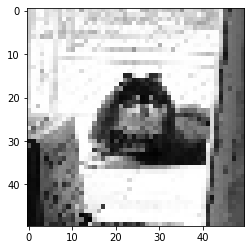


  1%|          | 16/2494 [00:00<00:20, 121.25it/s]

tensor([0.2713, 0.7287])


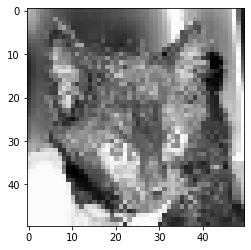


  1%|▏         | 33/2494 [00:00<00:19, 127.40it/s]

tensor([0.1211, 0.8789])


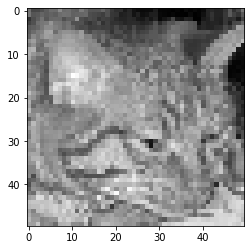


  2%|▏         | 53/2494 [00:00<00:17, 137.18it/s]

tensor([0.6458, 0.3542])


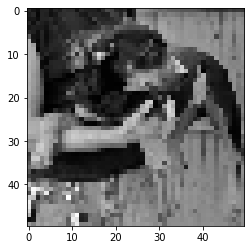

tensor([0.0013, 0.9987])


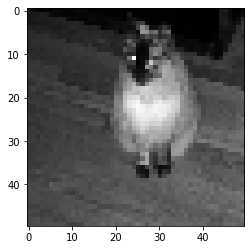


  3%|▎         | 63/2494 [00:00<00:27, 88.58it/s] 

tensor([0.9771, 0.0229])


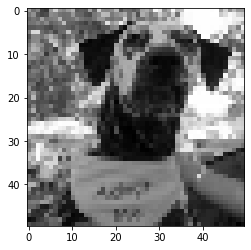

tensor([0.9769, 0.0231])


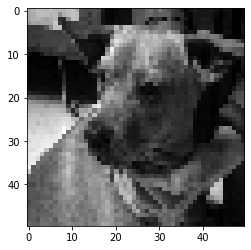


  3%|▎         | 72/2494 [00:00<00:35, 68.76it/s]

tensor([0.2421, 0.7579])


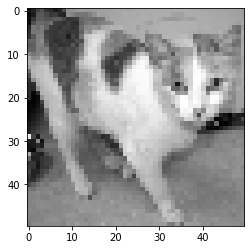


  3%|▎         | 80/2494 [00:00<00:34, 70.70it/s]

tensor([0.0230, 0.9770])


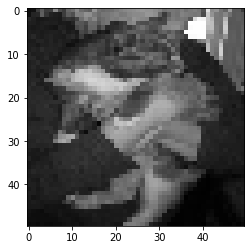


  4%|▎         | 89/2494 [00:00<00:32, 74.98it/s]

tensor([0.0045, 0.9955])


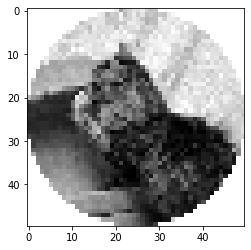

tensor([0.9252, 0.0748])


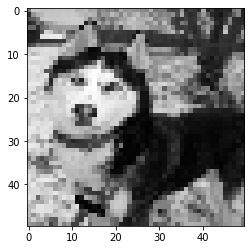

tensor([0.0039, 0.9961])


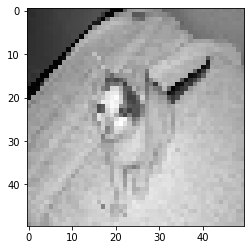


  4%|▍         | 97/2494 [00:01<00:55, 43.52it/s]

tensor([0.0594, 0.9406])


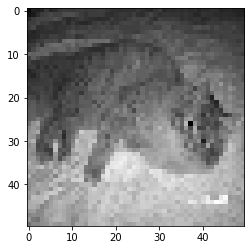


  4%|▍         | 104/2494 [00:01<00:50, 47.66it/s]

tensor([6.4363e-07, 1.0000e+00])


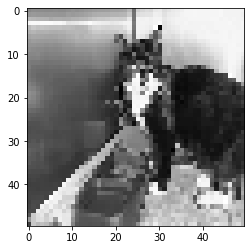


  4%|▍         | 111/2494 [00:01<00:46, 50.79it/s]

tensor([0.9626, 0.0374])


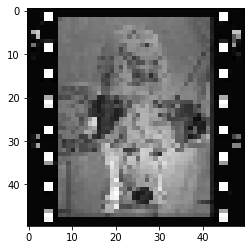


  5%|▍         | 118/2494 [00:01<00:43, 54.82it/s]

tensor([0.6896, 0.3104])


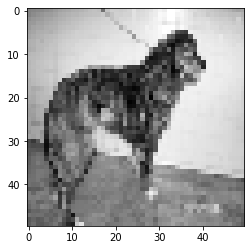


  5%|▌         | 125/2494 [00:01<00:40, 58.00it/s]

tensor([0.0063, 0.9937])


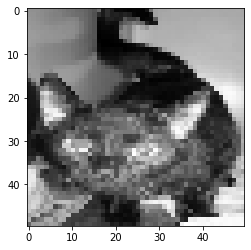


  5%|▌         | 132/2494 [00:01<00:39, 59.89it/s]

tensor([0.0545, 0.9455])


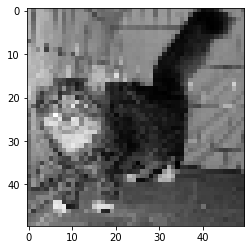


  6%|▌         | 139/2494 [00:02<00:38, 61.42it/s]

tensor([1.2317e-05, 9.9999e-01])


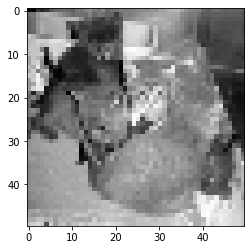


  6%|▌         | 146/2494 [00:02<00:37, 62.51it/s]

tensor([0.0132, 0.9868])


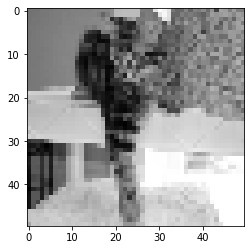

tensor([0.5013, 0.4987])


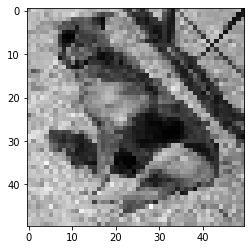

tensor([0.8714, 0.1286])


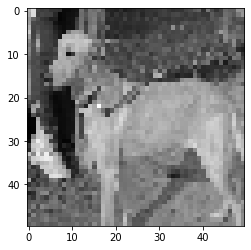


  6%|▌         | 153/2494 [00:02<00:58, 39.70it/s]

tensor([0.0272, 0.9728])


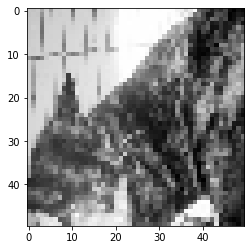


  6%|▋         | 159/2494 [00:02<00:52, 44.08it/s]

tensor([5.7705e-06, 9.9999e-01])


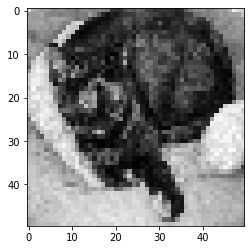

tensor([0.2462, 0.7538])


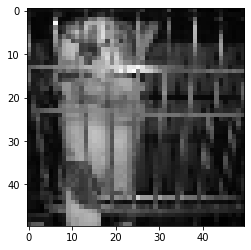

tensor([0.9986, 0.0014])


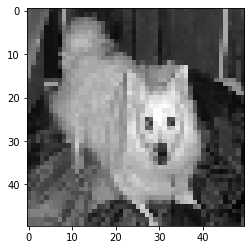

tensor([0.7614, 0.2386])


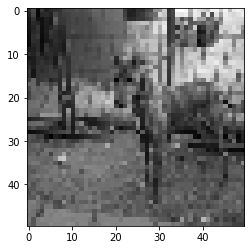


  7%|▋         | 165/2494 [00:02<01:27, 26.66it/s]

tensor([0.3885, 0.6115])


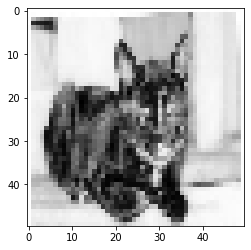


  7%|▋         | 172/2494 [00:03<01:12, 32.10it/s]

tensor([0.1117, 0.8883])


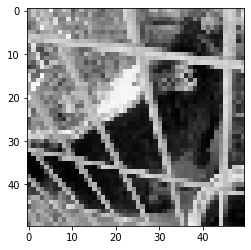


  7%|▋         | 181/2494 [00:03<00:59, 38.95it/s]

tensor([0.8499, 0.1501])


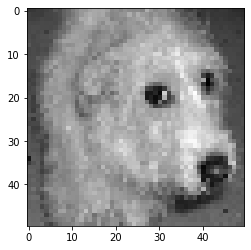


  8%|▊         | 192/2494 [00:03<00:49, 46.81it/s]

tensor([9.9998e-01, 2.1309e-05])


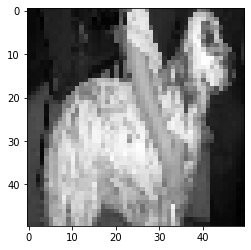

tensor([0.9979, 0.0021])


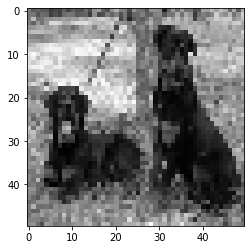

tensor([0.9840, 0.0160])


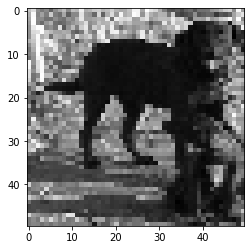


  8%|▊         | 199/2494 [00:03<01:19, 29.03it/s]

tensor([1.5491e-05, 9.9998e-01])


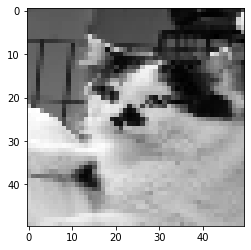


  8%|▊         | 205/2494 [00:03<01:09, 33.15it/s]

tensor([9.9976e-01, 2.3859e-04])


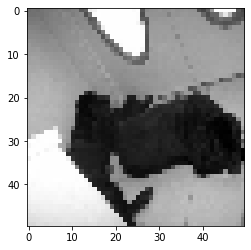

tensor([0.9857, 0.0143])


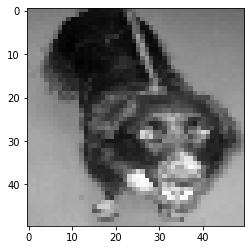


  8%|▊         | 211/2494 [00:04<01:11, 31.78it/s]

tensor([0.9639, 0.0361])


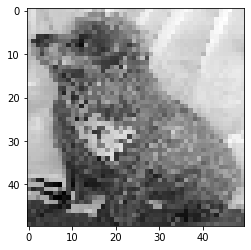


  9%|▊         | 216/2494 [00:04<01:04, 35.13it/s]

tensor([4.1432e-05, 9.9996e-01])


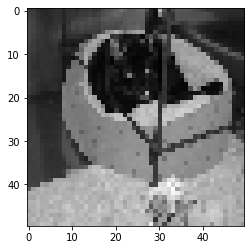


  9%|▉         | 222/2494 [00:04<00:57, 39.37it/s]

tensor([0.9874, 0.0126])


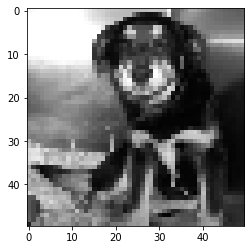


  9%|▉         | 227/2494 [00:04<00:55, 41.14it/s]

tensor([0.7919, 0.2081])


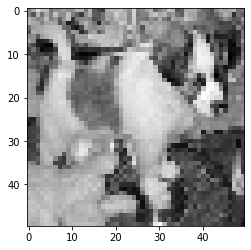

tensor([0.0124, 0.9876])


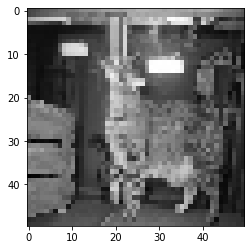


  9%|▉         | 232/2494 [00:04<01:05, 34.56it/s]

tensor([9.9999e-01, 1.2349e-05])


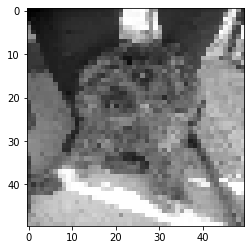

tensor([7.1081e-04, 9.9929e-01])


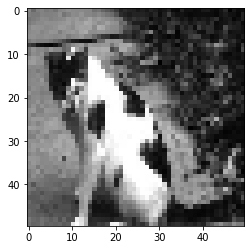


 10%|▉         | 237/2494 [00:04<01:15, 29.81it/s]

tensor([0.1717, 0.8283])


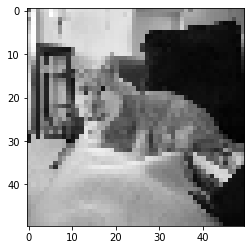


 10%|▉         | 247/2494 [00:04<01:02, 35.97it/s]

tensor([0.9927, 0.0073])


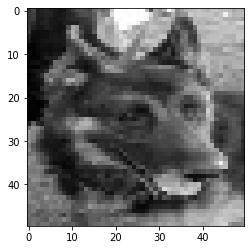


 10%|█         | 252/2494 [00:05<00:59, 37.40it/s]

tensor([3.1025e-04, 9.9969e-01])


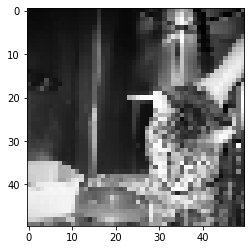


 10%|█         | 260/2494 [00:05<00:53, 41.41it/s]

tensor([0.6822, 0.3178])


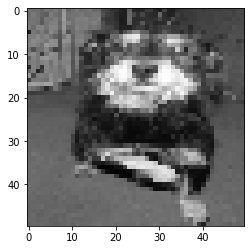


 11%|█         | 271/2494 [00:05<00:45, 48.88it/s]

tensor([0.4284, 0.5716])


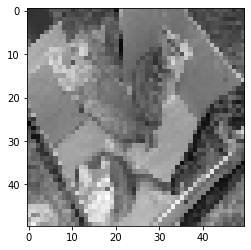


 11%|█         | 277/2494 [00:05<00:48, 45.83it/s]

tensor([0.1492, 0.8508])


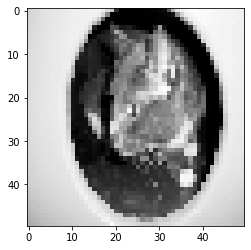

tensor([0.9748, 0.0252])


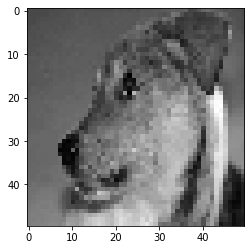


 11%|█▏        | 283/2494 [00:05<01:00, 36.39it/s]

tensor([0.9903, 0.0097])


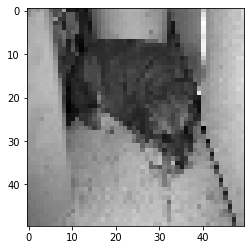


 12%|█▏        | 288/2494 [00:05<00:57, 38.63it/s]

tensor([0.0010, 0.9990])


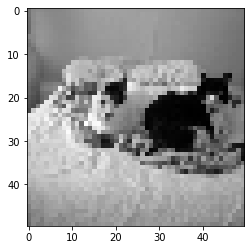


 12%|█▏        | 297/2494 [00:06<00:48, 45.32it/s]

tensor([0.1435, 0.8565])


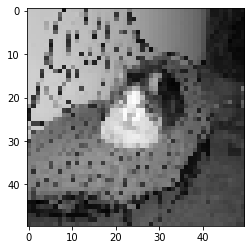


 12%|█▏        | 303/2494 [00:06<00:46, 46.95it/s]

tensor([0.5075, 0.4925])


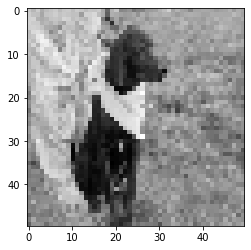


 12%|█▏        | 311/2494 [00:06<00:42, 51.63it/s]

tensor([0.9939, 0.0061])


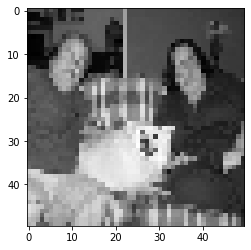

tensor([0.0060, 0.9940])


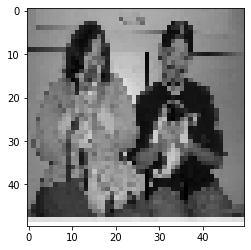


 13%|█▎        | 317/2494 [00:06<00:58, 37.35it/s]

tensor([0.9945, 0.0055])


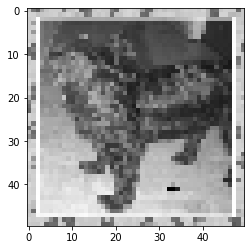


 13%|█▎        | 322/2494 [00:06<00:57, 37.91it/s]

tensor([0.5180, 0.4820])


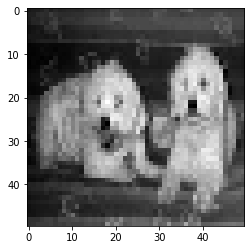


 13%|█▎        | 330/2494 [00:06<00:49, 43.45it/s]

tensor([9.9980e-01, 1.9784e-04])


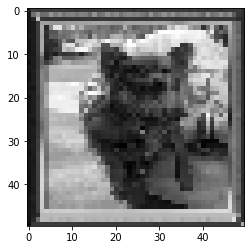


 13%|█▎        | 336/2494 [00:06<00:47, 45.30it/s]

tensor([0.7230, 0.2770])


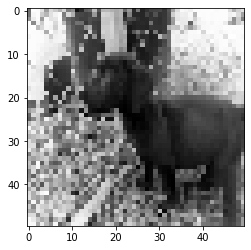


 14%|█▎        | 342/2494 [00:07<00:46, 46.65it/s]

tensor([0.7701, 0.2299])


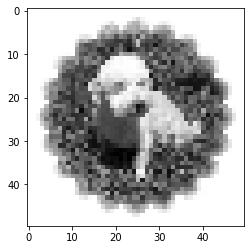


 14%|█▍        | 348/2494 [00:07<00:44, 48.14it/s]

tensor([0.8875, 0.1125])


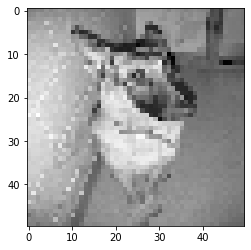


 14%|█▍        | 354/2494 [00:07<00:43, 49.06it/s]

tensor([0.9971, 0.0029])


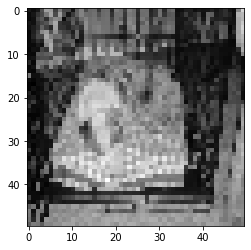


 15%|█▍        | 362/2494 [00:07<00:39, 53.41it/s]

tensor([0.1753, 0.8247])


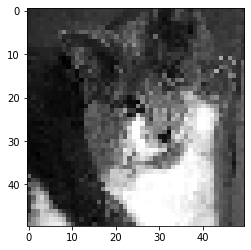


 15%|█▍        | 371/2494 [00:07<00:36, 58.38it/s]

tensor([0.9565, 0.0435])


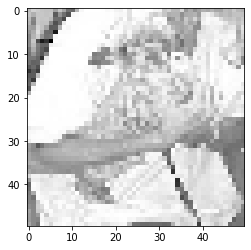


 15%|█▌        | 378/2494 [00:07<00:36, 57.36it/s]

tensor([0.9067, 0.0933])


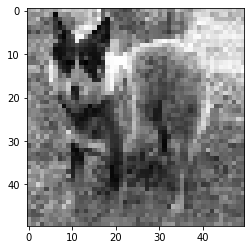


 15%|█▌        | 384/2494 [00:07<00:42, 49.87it/s]

tensor([0.2059, 0.7941])


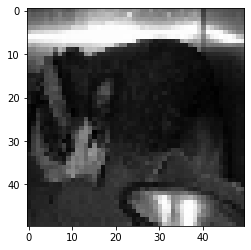

tensor([0.8024, 0.1976])


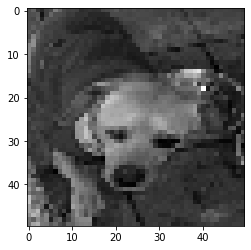

tensor([0.0050, 0.9950])


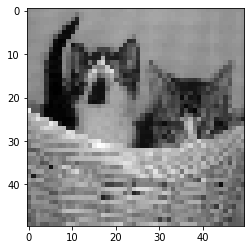

tensor([0.0075, 0.9925])


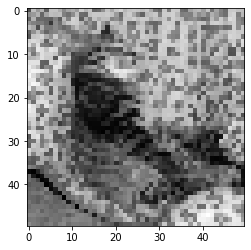


 16%|█▌        | 390/2494 [00:08<01:17, 27.00it/s]

tensor([0.9810, 0.0190])


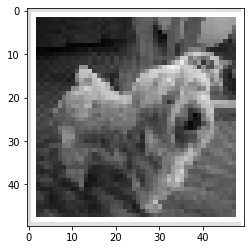


 16%|█▌        | 395/2494 [00:08<01:10, 29.90it/s]

tensor([0.1954, 0.8046])


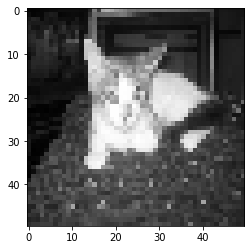

tensor([0.0622, 0.9378])


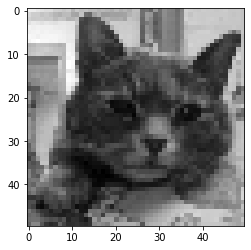


 16%|█▌        | 400/2494 [00:08<01:17, 26.86it/s]

tensor([0.9672, 0.0328])


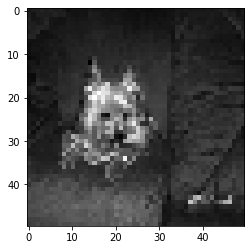


 16%|█▌        | 404/2494 [00:08<01:13, 28.41it/s]

tensor([0.3317, 0.6683])


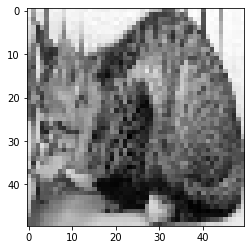


 16%|█▋        | 408/2494 [00:08<01:10, 29.47it/s]

tensor([0.1057, 0.8943])


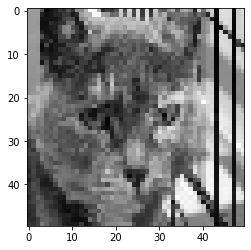


 17%|█▋        | 413/2494 [00:08<01:05, 31.85it/s]

tensor([0.2695, 0.7305])


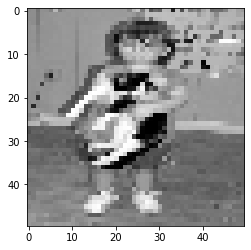


 17%|█▋        | 417/2494 [00:09<01:11, 29.09it/s]

tensor([0.6185, 0.3815])


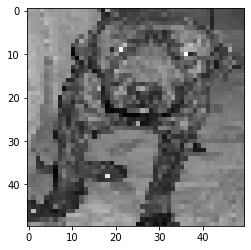

tensor([0.3705, 0.6295])


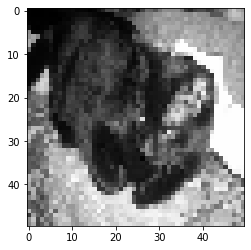


 17%|█▋        | 421/2494 [00:09<01:25, 24.28it/s]

tensor([0.9986, 0.0014])


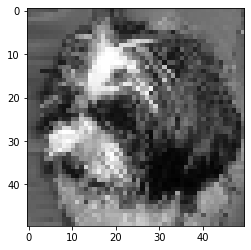

tensor([0.6203, 0.3797])


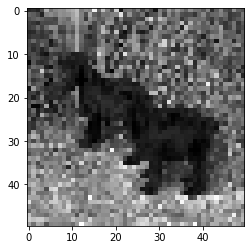


 17%|█▋        | 424/2494 [00:09<01:49, 18.95it/s]

tensor([0.0178, 0.9822])


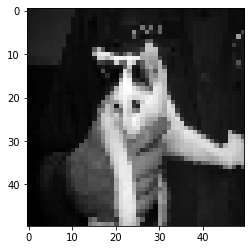


 17%|█▋        | 427/2494 [00:09<01:45, 19.58it/s]

tensor([0.8944, 0.1056])


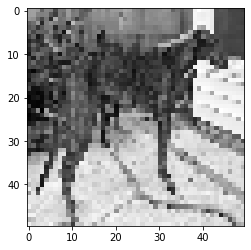


 17%|█▋        | 430/2494 [00:09<01:44, 19.70it/s]

tensor([0.0209, 0.9791])


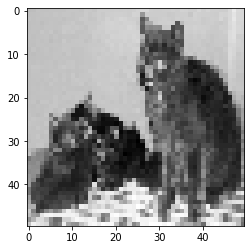


 17%|█▋        | 434/2494 [00:10<01:34, 21.83it/s]

tensor([9.9928e-01, 7.1726e-04])


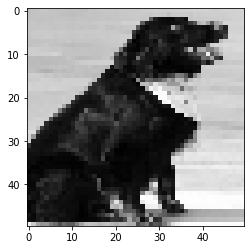


 18%|█▊        | 437/2494 [00:10<01:36, 21.35it/s]

tensor([0.0553, 0.9447])


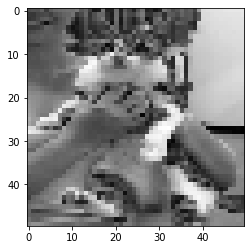


 18%|█▊        | 458/2494 [00:10<01:11, 28.60it/s]

tensor([0.0050, 0.9950])


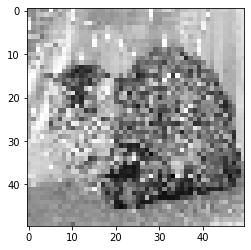


 19%|█▊        | 464/2494 [00:10<01:03, 31.96it/s]

tensor([0.5002, 0.4998])


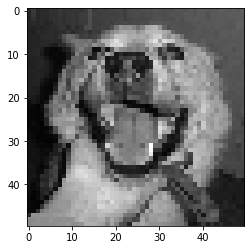

tensor([0.0390, 0.9610])


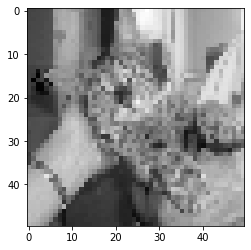


 19%|█▉        | 470/2494 [00:10<01:17, 26.02it/s]

tensor([0.0194, 0.9806])


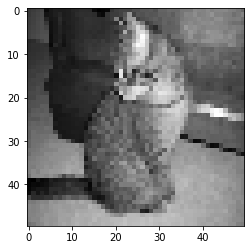

tensor([0.8527, 0.1473])


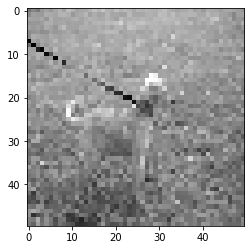


 19%|█▉        | 475/2494 [00:11<01:27, 23.06it/s]

tensor([0.0044, 0.9956])


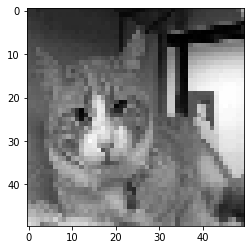

tensor([0.8539, 0.1461])


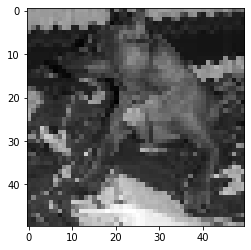


 19%|█▉        | 479/2494 [00:11<01:38, 20.50it/s]

tensor([0.2171, 0.7829])


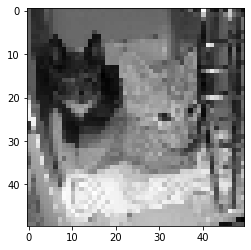

tensor([0.4098, 0.5902])


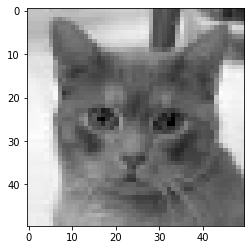


 19%|█▉        | 482/2494 [00:11<02:09, 15.52it/s]

tensor([4.6920e-06, 1.0000e+00])


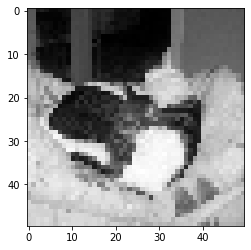


 19%|█▉        | 485/2494 [00:11<02:01, 16.57it/s]

tensor([0.4715, 0.5285])


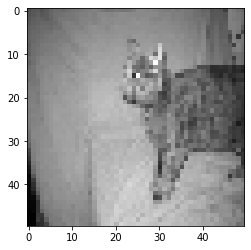


 20%|█▉        | 488/2494 [00:11<01:55, 17.40it/s]

tensor([0.5852, 0.4148])


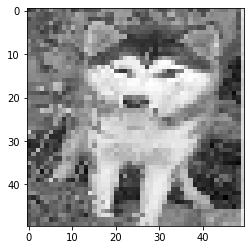


 20%|█▉        | 491/2494 [00:12<01:47, 18.68it/s]

tensor([0.2869, 0.7131])


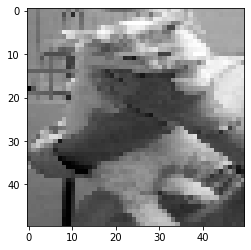


 20%|█▉        | 494/2494 [00:12<01:49, 18.27it/s]

tensor([0.2890, 0.7110])


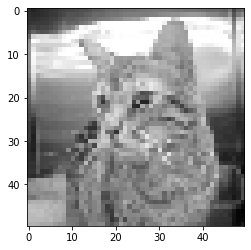


 20%|██        | 499/2494 [00:12<01:32, 21.59it/s]

tensor([0.6876, 0.3124])


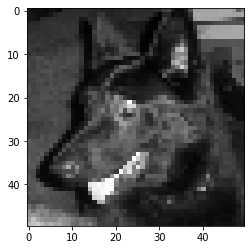


 20%|██        | 502/2494 [00:12<01:34, 21.10it/s]

tensor([0.1076, 0.8924])


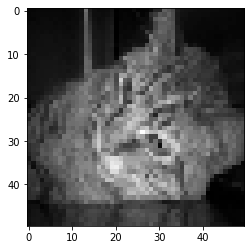


 20%|██        | 508/2494 [00:12<01:19, 24.85it/s]

tensor([0.5370, 0.4630])


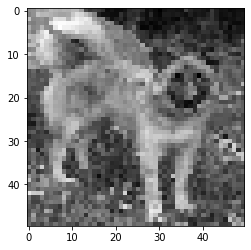


 21%|██        | 512/2494 [00:12<01:13, 26.84it/s]

tensor([0.2498, 0.7502])


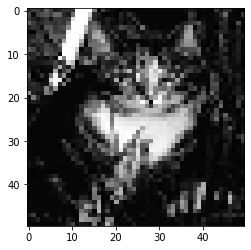

tensor([0.9069, 0.0931])


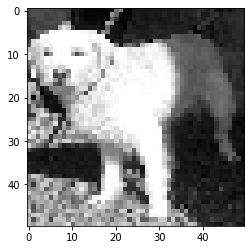


 21%|██        | 516/2494 [00:13<01:29, 22.04it/s]

tensor([0.2795, 0.7205])


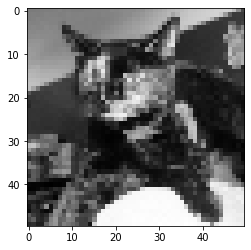


 21%|██        | 519/2494 [00:13<01:38, 19.95it/s]

tensor([0.9351, 0.0649])


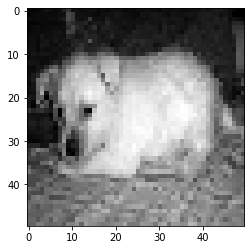

tensor([0.9879, 0.0121])


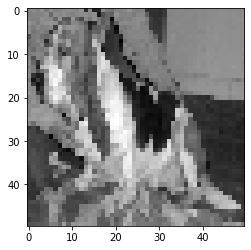


 21%|██        | 522/2494 [00:13<02:12, 14.94it/s]

tensor([9.9972e-01, 2.7547e-04])


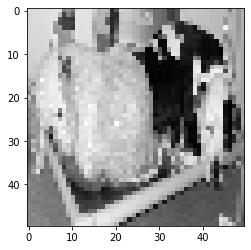


 21%|██        | 524/2494 [00:13<02:07, 15.46it/s]

tensor([0.3024, 0.6976])


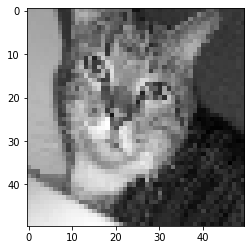


 21%|██▏       | 532/2494 [00:13<01:41, 19.29it/s]

tensor([0.5389, 0.4611])


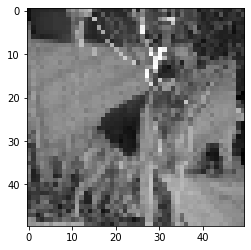


 21%|██▏       | 535/2494 [00:13<01:38, 19.90it/s]

tensor([0.0042, 0.9958])


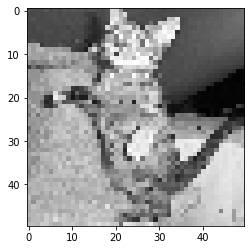

tensor([0.4716, 0.5284])


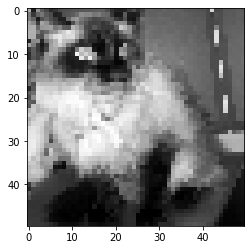


 22%|██▏       | 538/2494 [00:14<01:58, 16.46it/s]

tensor([0.0050, 0.9950])


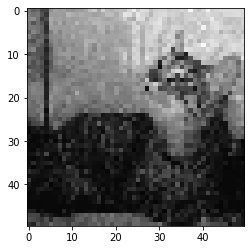


 22%|██▏       | 548/2494 [00:14<01:30, 21.47it/s]

tensor([0.2655, 0.7345])


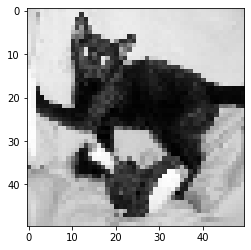

tensor([0.4184, 0.5816])


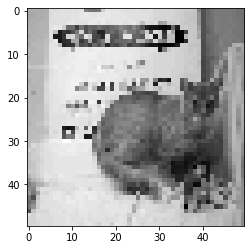

tensor([0.1203, 0.8797])


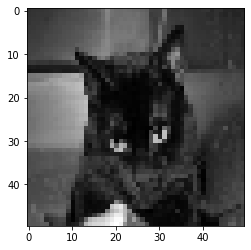


 22%|██▏       | 552/2494 [00:14<01:52, 17.20it/s]

tensor([9.9996e-01, 3.8204e-05])


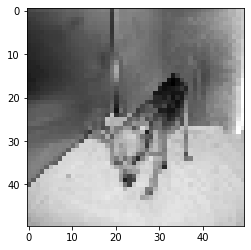


 22%|██▏       | 558/2494 [00:14<01:30, 21.42it/s]

tensor([0.8918, 0.1082])


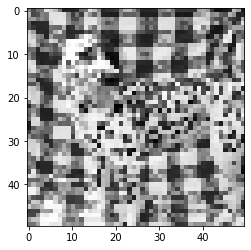

tensor([0.8264, 0.1736])


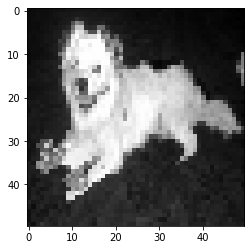


 23%|██▎       | 562/2494 [00:15<01:35, 20.26it/s]

tensor([9.9999e-01, 8.9554e-06])


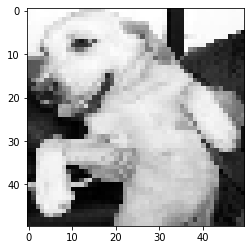


 23%|██▎       | 566/2494 [00:15<01:28, 21.70it/s]

tensor([0.9690, 0.0310])


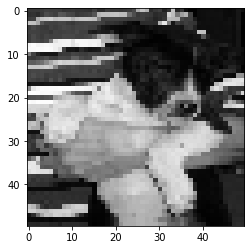


 23%|██▎       | 569/2494 [00:15<01:26, 22.16it/s]

tensor([3.9634e-04, 9.9960e-01])


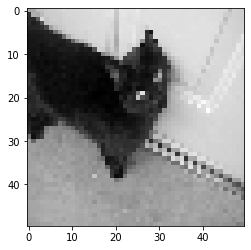


 23%|██▎       | 572/2494 [00:15<01:26, 22.15it/s]

tensor([0.0426, 0.9574])


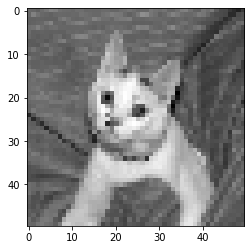


 23%|██▎       | 575/2494 [00:15<01:25, 22.36it/s]

tensor([9.9910e-01, 9.0405e-04])


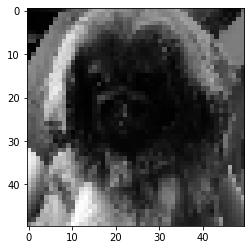


 23%|██▎       | 581/2494 [00:15<01:13, 26.14it/s]

tensor([0.9473, 0.0527])


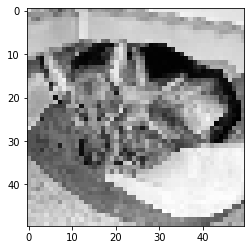


 23%|██▎       | 585/2494 [00:15<01:09, 27.64it/s]

tensor([9.7650e-05, 9.9990e-01])


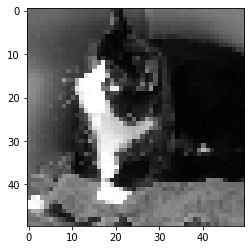

tensor([1.0000e+00, 5.1745e-07])


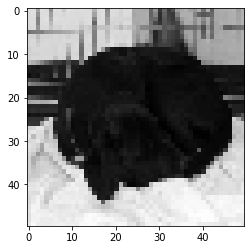


 24%|██▎       | 589/2494 [00:16<01:23, 22.83it/s]

tensor([0.9984, 0.0016])


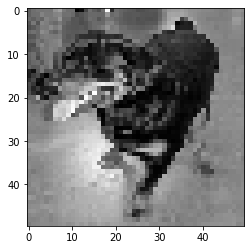


 24%|██▎       | 592/2494 [00:16<01:21, 23.40it/s]

tensor([0.0038, 0.9962])


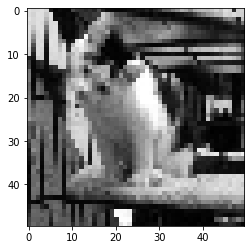

tensor([0.0011, 0.9989])


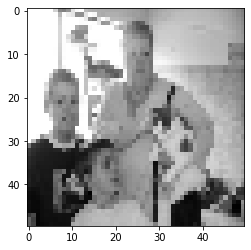


 24%|██▍       | 595/2494 [00:16<01:49, 17.29it/s]

tensor([0.7811, 0.2189])


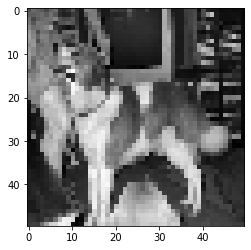


 24%|██▍       | 598/2494 [00:16<01:51, 17.07it/s]

tensor([0.3923, 0.6077])


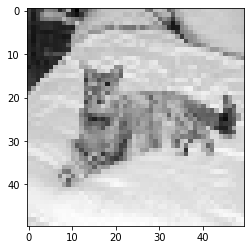


 24%|██▍       | 605/2494 [00:16<01:29, 21.11it/s]

tensor([0.8930, 0.1070])


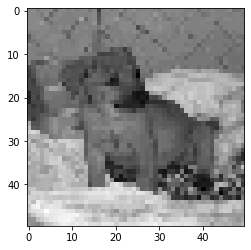


 24%|██▍       | 608/2494 [00:16<01:29, 21.10it/s]

tensor([0.9899, 0.0101])


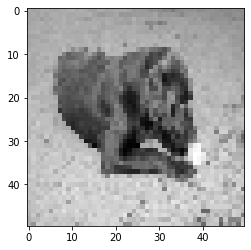


 24%|██▍       | 611/2494 [00:17<01:27, 21.60it/s]

tensor([0.0940, 0.9060])


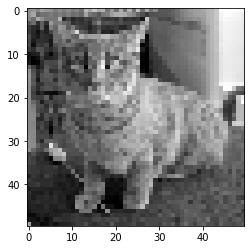


 25%|██▍       | 614/2494 [00:17<01:25, 21.99it/s]

tensor([0.8925, 0.1075])


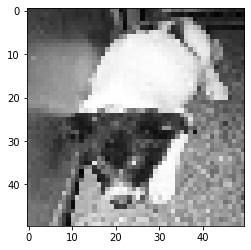


 25%|██▍       | 620/2494 [00:17<01:12, 25.94it/s]

tensor([0.0015, 0.9985])


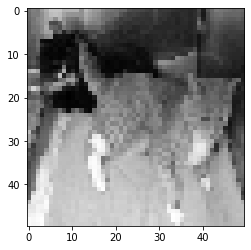


 25%|██▌       | 626/2494 [00:17<01:02, 29.73it/s]

tensor([0.9538, 0.0462])


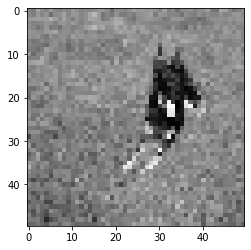


 25%|██▌       | 630/2494 [00:17<01:01, 30.25it/s]

tensor([0.3208, 0.6792])


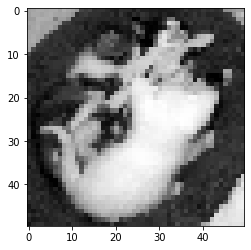


 25%|██▌       | 635/2494 [00:17<00:57, 32.50it/s]

tensor([1.4741e-04, 9.9985e-01])


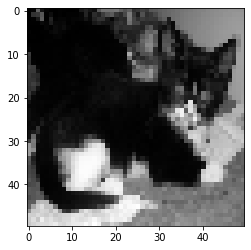

tensor([0.9817, 0.0183])


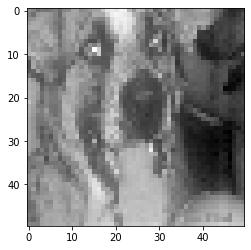


 26%|██▌       | 639/2494 [00:18<01:17, 24.01it/s]

tensor([0.4357, 0.5643])


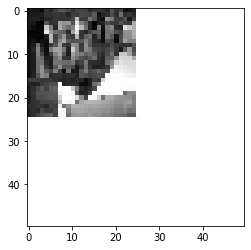

tensor([0.0047, 0.9953])


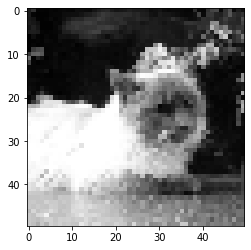


 26%|██▌       | 642/2494 [00:18<02:01, 15.29it/s]

tensor([0.0577, 0.9423])


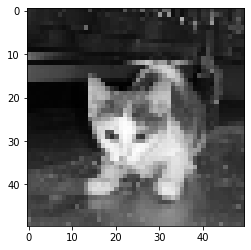


 26%|██▌       | 653/2494 [00:18<01:32, 19.92it/s]

tensor([0.0044, 0.9956])


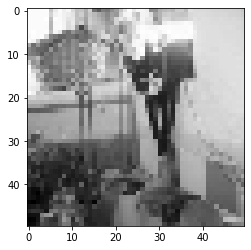


 26%|██▋       | 657/2494 [00:18<01:23, 21.99it/s]

tensor([0.0017, 0.9983])


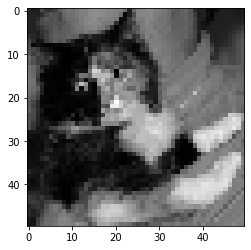


 27%|██▋       | 661/2494 [00:18<01:17, 23.69it/s]

tensor([0.0174, 0.9826])


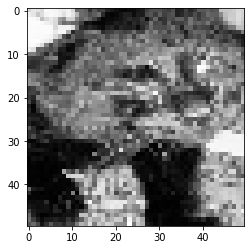


 27%|██▋       | 666/2494 [00:18<01:10, 25.83it/s]

tensor([0.9623, 0.0377])


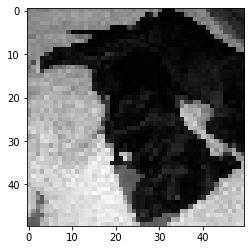

tensor([8.0042e-04, 9.9920e-01])


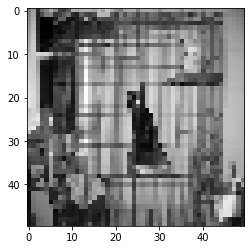


 27%|██▋       | 670/2494 [00:19<01:31, 19.88it/s]

tensor([0.6310, 0.3690])


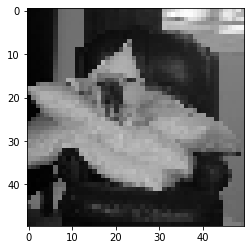


 27%|██▋       | 683/2494 [00:19<01:10, 25.56it/s]

tensor([0.7297, 0.2703])


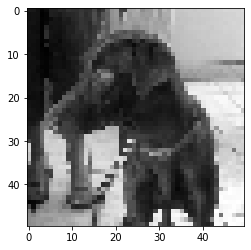

tensor([0.0633, 0.9367])


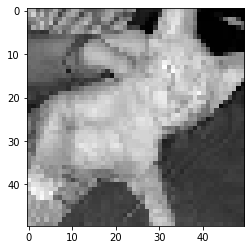


 28%|██▊       | 688/2494 [00:19<01:21, 22.14it/s]

tensor([0.7691, 0.2309])


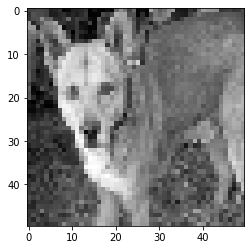


 28%|██▊       | 692/2494 [00:19<01:23, 21.58it/s]

tensor([0.9932, 0.0068])


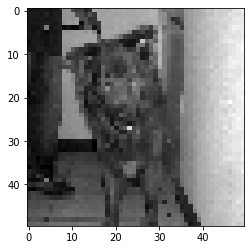


 28%|██▊       | 696/2494 [00:20<01:19, 22.56it/s]

tensor([9.6138e-04, 9.9904e-01])


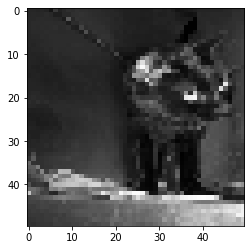


 28%|██▊       | 699/2494 [00:20<01:22, 21.81it/s]

tensor([9.9979e-01, 2.1494e-04])


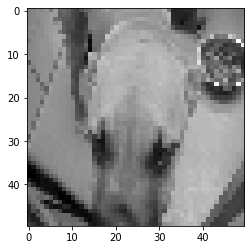


 28%|██▊       | 702/2494 [00:20<01:24, 21.15it/s]

tensor([5.3737e-05, 9.9995e-01])


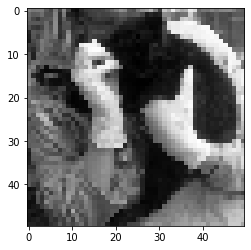


 28%|██▊       | 705/2494 [00:20<01:26, 20.57it/s]

tensor([0.9915, 0.0085])


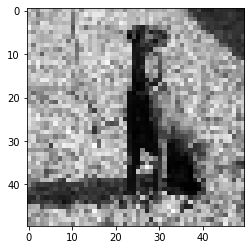


 29%|██▊       | 712/2494 [00:20<01:12, 24.57it/s]

tensor([0.0041, 0.9959])


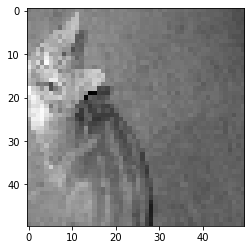


 29%|██▊       | 715/2494 [00:20<01:17, 23.02it/s]

tensor([0.1316, 0.8684])


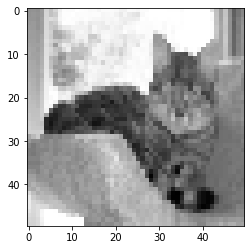


 29%|██▉       | 721/2494 [00:21<01:07, 26.25it/s]

tensor([0.3301, 0.6699])


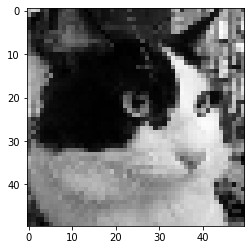


 29%|██▉       | 727/2494 [00:21<01:00, 29.32it/s]

tensor([0.6085, 0.3915])


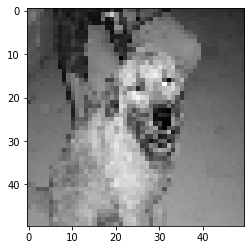


 29%|██▉       | 731/2494 [00:21<01:00, 29.03it/s]

tensor([0.1060, 0.8940])


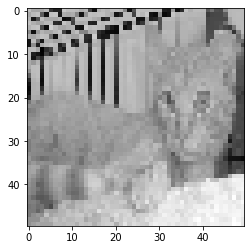


 29%|██▉       | 735/2494 [00:21<01:03, 27.90it/s]

tensor([0.4177, 0.5823])


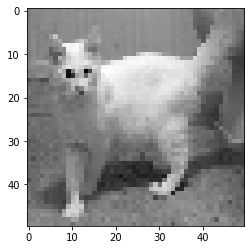


 30%|██▉       | 738/2494 [00:21<01:16, 23.05it/s]

tensor([9.9978e-01, 2.2126e-04])


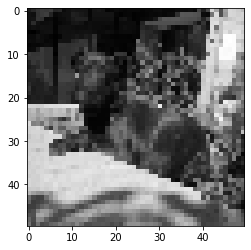


 30%|██▉       | 741/2494 [00:21<01:21, 21.59it/s]

tensor([0.8484, 0.1516])


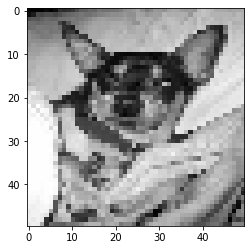


 30%|██▉       | 744/2494 [00:21<01:21, 21.45it/s]

tensor([0.0091, 0.9909])


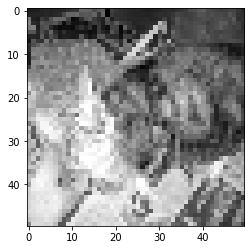


 30%|███       | 750/2494 [00:22<01:09, 25.11it/s]

tensor([0.9880, 0.0120])


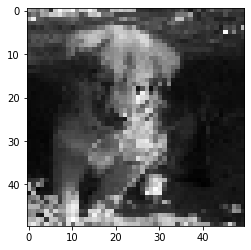


 30%|███       | 758/2494 [00:22<01:00, 28.90it/s]

tensor([0.9688, 0.0312])


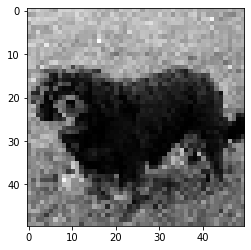


 31%|███       | 762/2494 [00:22<01:01, 28.02it/s]

tensor([0.0042, 0.9958])


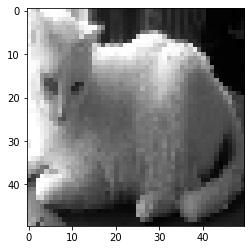


 31%|███       | 768/2494 [00:22<00:55, 31.17it/s]

tensor([0.2573, 0.7427])


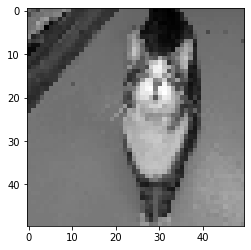


 31%|███       | 772/2494 [00:22<00:56, 30.37it/s]

tensor([0.0743, 0.9257])


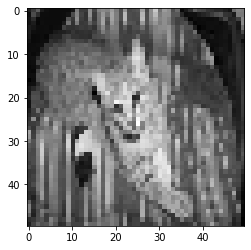


 31%|███       | 776/2494 [00:22<00:58, 29.61it/s]

tensor([0.7949, 0.2051])


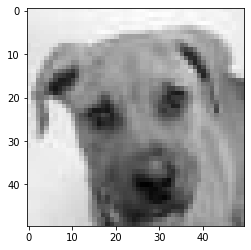


 31%|███▏      | 783/2494 [00:22<00:51, 33.21it/s]

tensor([0.9929, 0.0071])


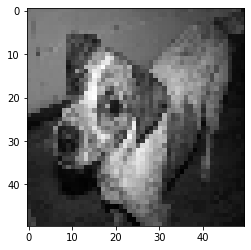


 33%|███▎      | 811/2494 [00:23<00:38, 43.49it/s]

tensor([0.7836, 0.2164])


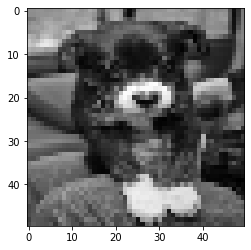

tensor([0.9974, 0.0026])


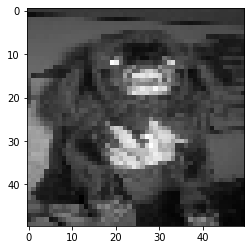


 33%|███▎      | 819/2494 [00:23<00:49, 34.12it/s]

tensor([0.4598, 0.5402])


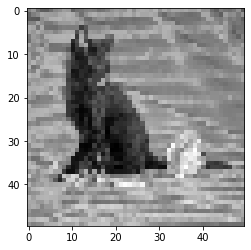


 33%|███▎      | 825/2494 [00:23<00:49, 33.49it/s]

tensor([0.0187, 0.9813])


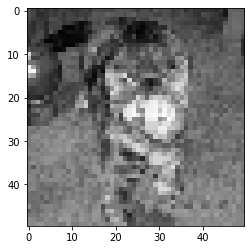


 33%|███▎      | 833/2494 [00:23<00:44, 37.61it/s]

tensor([0.9988, 0.0012])


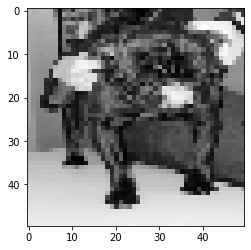


 34%|███▍      | 846/2494 [00:24<00:37, 43.49it/s]

tensor([0.3950, 0.6050])


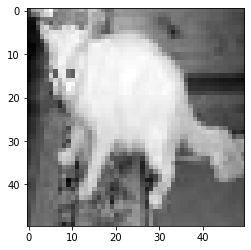

tensor([3.8215e-07, 1.0000e+00])


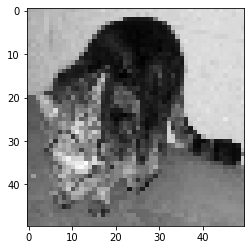


 34%|███▍      | 852/2494 [00:24<00:54, 30.23it/s]

tensor([0.8324, 0.1676])


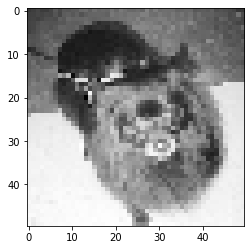


 34%|███▍      | 857/2494 [00:24<00:53, 30.52it/s]

tensor([0.3543, 0.6457])


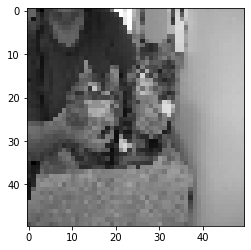


 35%|███▍      | 865/2494 [00:24<00:47, 34.40it/s]

tensor([0.0384, 0.9616])


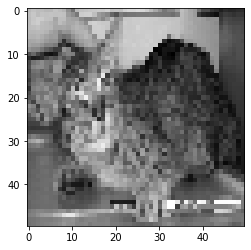

tensor([0.6006, 0.3994])


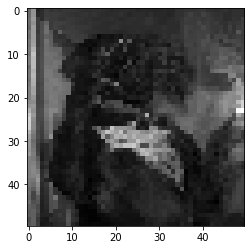

tensor([0.9903, 0.0097])


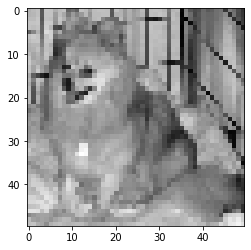


 35%|███▍      | 870/2494 [00:25<01:19, 20.50it/s]

tensor([0.0628, 0.9372])


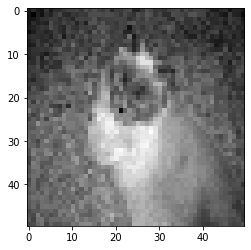


 35%|███▌      | 874/2494 [00:25<01:11, 22.66it/s]

tensor([0.7705, 0.2295])


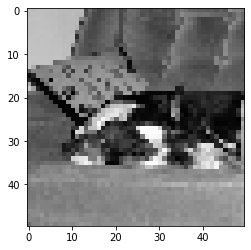


 35%|███▌      | 878/2494 [00:25<01:06, 24.28it/s]

tensor([0.0633, 0.9367])


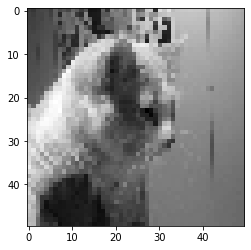


 35%|███▌      | 885/2494 [00:25<00:55, 28.74it/s]

tensor([0.2539, 0.7461])


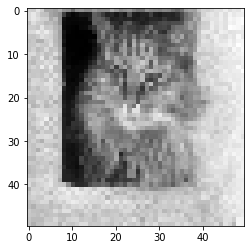


 36%|███▌      | 889/2494 [00:25<00:55, 29.06it/s]

tensor([0.9743, 0.0257])


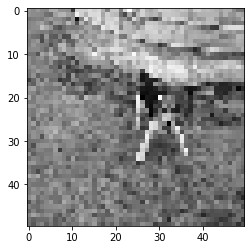


 36%|███▌      | 893/2494 [00:25<00:54, 29.25it/s]

tensor([0.3416, 0.6584])


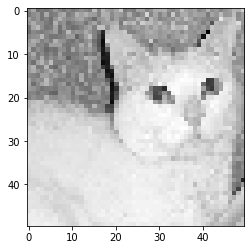


 36%|███▌      | 898/2494 [00:25<00:50, 31.30it/s]

tensor([0.0041, 0.9959])


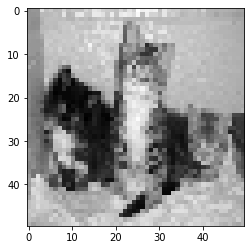


 36%|███▌      | 903/2494 [00:26<00:48, 32.94it/s]

tensor([0.0029, 0.9971])


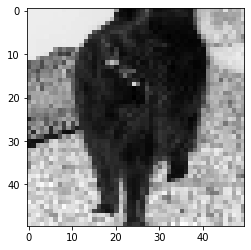


 36%|███▋      | 907/2494 [00:26<00:51, 31.03it/s]

tensor([0.9309, 0.0691])


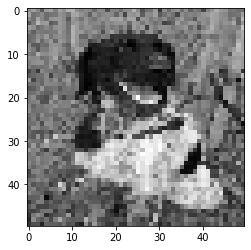


 37%|███▋      | 911/2494 [00:26<00:57, 27.77it/s]

tensor([0.0024, 0.9976])


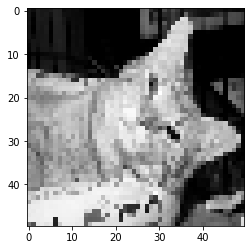


 37%|███▋      | 916/2494 [00:26<00:55, 28.42it/s]

tensor([0.6176, 0.3824])


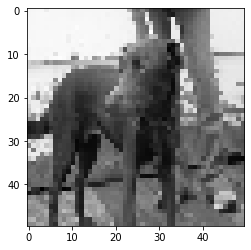


 37%|███▋      | 919/2494 [00:26<01:11, 22.02it/s]

tensor([0.7254, 0.2746])


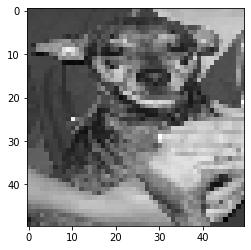


 37%|███▋      | 924/2494 [00:26<01:02, 24.94it/s]

tensor([0.3531, 0.6469])


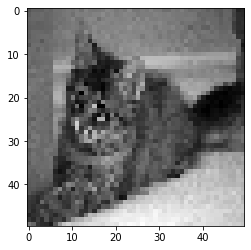


 37%|███▋      | 928/2494 [00:27<00:59, 26.15it/s]

tensor([0.0695, 0.9305])


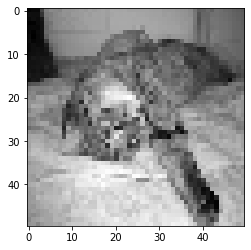


 37%|███▋      | 931/2494 [00:27<01:04, 24.09it/s]

tensor([0.0041, 0.9959])


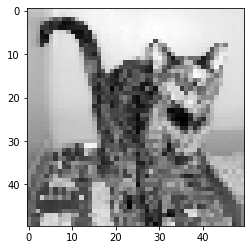


 37%|███▋      | 934/2494 [00:27<01:07, 23.16it/s]

tensor([0.0249, 0.9751])


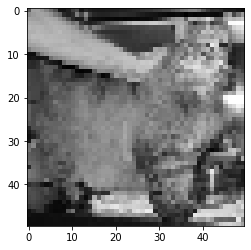


 38%|███▊      | 937/2494 [00:27<01:08, 22.76it/s]

tensor([0.1330, 0.8670])


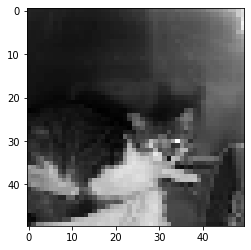


 38%|███▊      | 941/2494 [00:27<01:04, 23.90it/s]

tensor([0.0054, 0.9946])


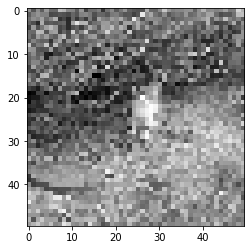


 38%|███▊      | 947/2494 [00:27<00:58, 26.62it/s]

tensor([1.0000e+00, 1.0772e-07])


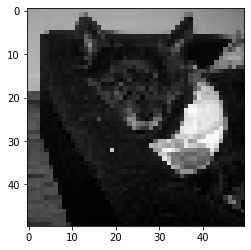

tensor([1.0000e+00, 3.4068e-08])


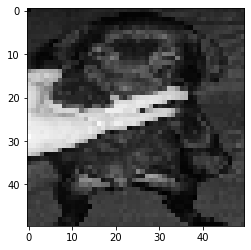


 38%|███▊      | 950/2494 [00:28<01:27, 17.65it/s]

tensor([0.7683, 0.2317])


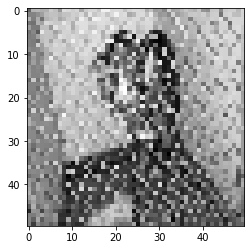


 39%|███▉      | 967/2494 [00:28<01:06, 23.09it/s]

tensor([0.9987, 0.0013])


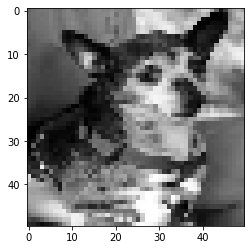


 39%|███▉      | 972/2494 [00:28<01:04, 23.76it/s]

tensor([0.9313, 0.0687])


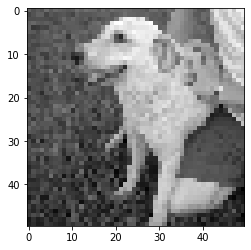


 39%|███▉      | 976/2494 [00:28<01:05, 23.06it/s]

tensor([9.9999e-01, 1.0445e-05])


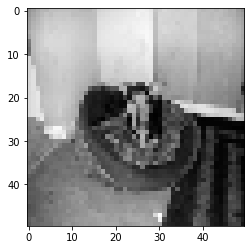


 39%|███▉      | 980/2494 [00:28<01:04, 23.38it/s]

tensor([0.0058, 0.9942])


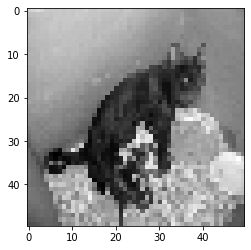


 39%|███▉      | 983/2494 [00:29<01:08, 21.93it/s]

tensor([0.0696, 0.9304])


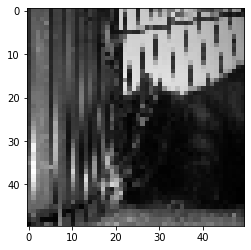


 40%|███▉      | 986/2494 [00:29<01:12, 20.76it/s]

tensor([0.2189, 0.7811])


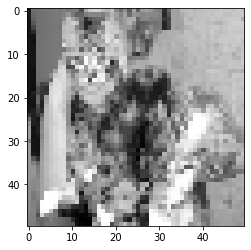


 40%|███▉      | 989/2494 [00:29<01:12, 20.79it/s]

tensor([0.0031, 0.9969])


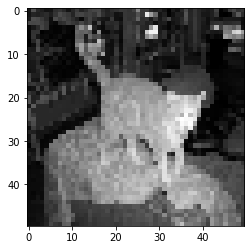

tensor([0.1790, 0.8210])


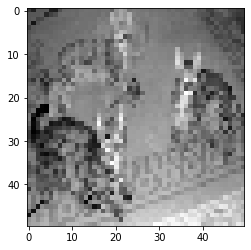


 40%|███▉      | 992/2494 [00:29<01:31, 16.43it/s]

tensor([0.1539, 0.8461])


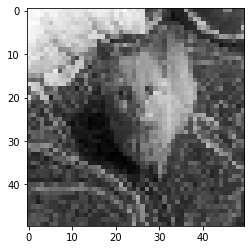


 40%|████      | 998/2494 [00:29<01:14, 20.13it/s]

tensor([0.6183, 0.3817])


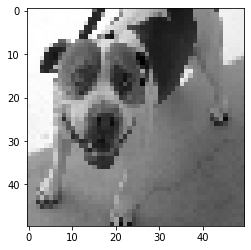


 40%|████      | 1004/2494 [00:29<01:02, 23.98it/s]

tensor([9.9997e-01, 2.7427e-05])


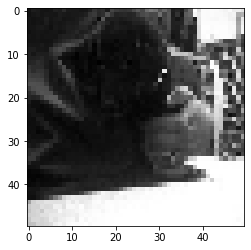


 40%|████      | 1009/2494 [00:30<00:55, 26.77it/s]

tensor([0.8941, 0.1059])


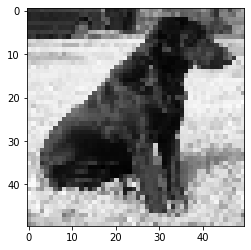


 41%|████      | 1014/2494 [00:30<00:54, 27.28it/s]

tensor([0.9566, 0.0434])


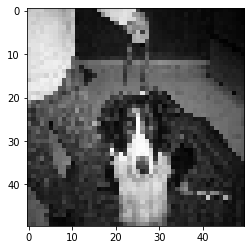


 41%|████      | 1020/2494 [00:30<00:47, 30.71it/s]

tensor([0.4823, 0.5177])


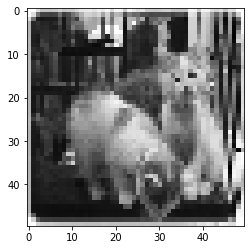


 41%|████▏     | 1031/2494 [00:30<00:39, 37.28it/s]

tensor([0.4446, 0.5554])


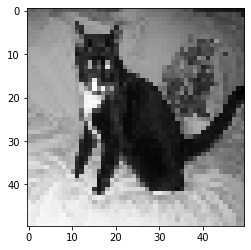


 42%|████▏     | 1036/2494 [00:30<00:41, 35.24it/s]

tensor([0.1480, 0.8520])


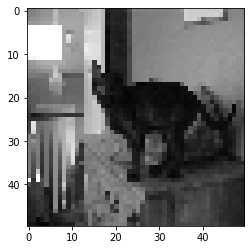


 42%|████▏     | 1045/2494 [00:30<00:36, 39.88it/s]

tensor([0.0175, 0.9825])


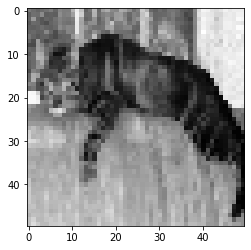


 42%|████▏     | 1050/2494 [00:30<00:39, 36.89it/s]

tensor([0.0385, 0.9615])


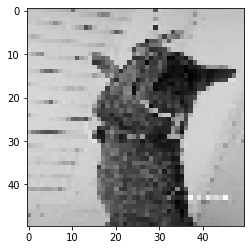

tensor([0.0642, 0.9358])


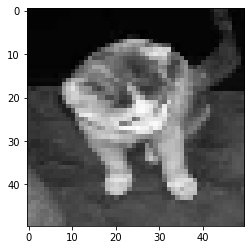

tensor([0.9524, 0.0476])


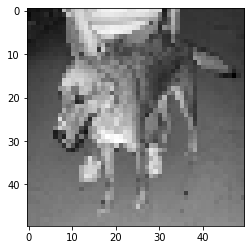


 42%|████▏     | 1055/2494 [00:31<01:04, 22.32it/s]

tensor([0.9879, 0.0121])


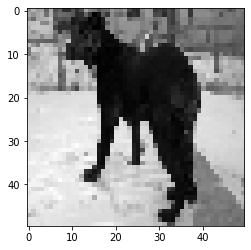


 43%|████▎     | 1061/2494 [00:31<00:55, 25.91it/s]

tensor([0.9941, 0.0059])


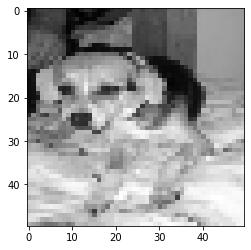


 43%|████▎     | 1065/2494 [00:31<00:54, 26.42it/s]

tensor([0.7505, 0.2495])


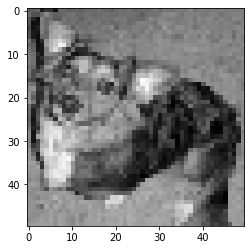

tensor([0.9952, 0.0048])


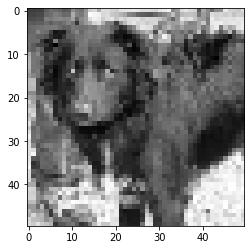


 43%|████▎     | 1069/2494 [00:32<01:11, 19.82it/s]

tensor([0.7936, 0.2064])


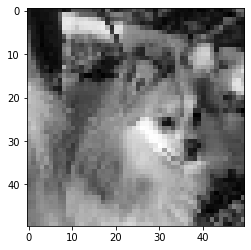


 43%|████▎     | 1072/2494 [00:32<01:09, 20.33it/s]

tensor([0.0126, 0.9874])


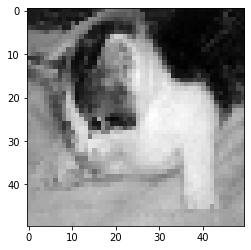


 43%|████▎     | 1077/2494 [00:32<01:02, 22.71it/s]

tensor([0.4317, 0.5683])


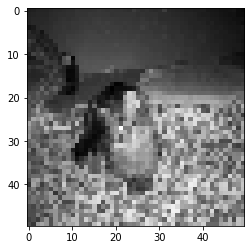

tensor([0.9027, 0.0973])


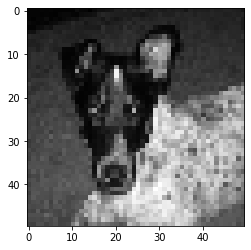

tensor([0.0051, 0.9949])


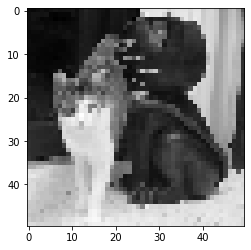


 43%|████▎     | 1080/2494 [00:32<01:43, 13.60it/s]

tensor([0.1317, 0.8683])


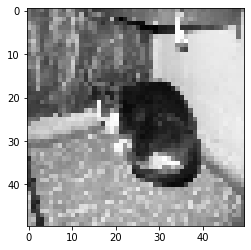

tensor([0.9631, 0.0369])


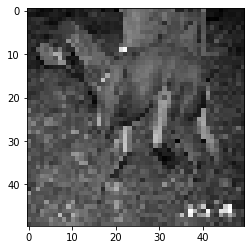

tensor([5.6448e-05, 9.9994e-01])


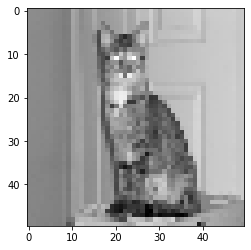


 43%|████▎     | 1083/2494 [00:33<02:10, 10.82it/s]

tensor([0.0175, 0.9825])


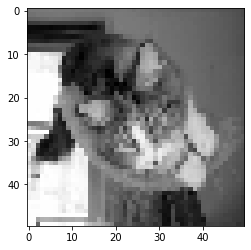


 44%|████▍     | 1096/2494 [00:33<01:36, 14.53it/s]

tensor([0.9974, 0.0026])


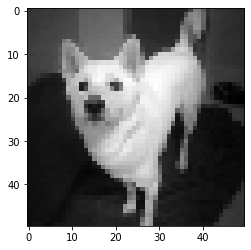


 44%|████▍     | 1100/2494 [00:33<01:25, 16.29it/s]

tensor([1.0000e+00, 1.7582e-06])


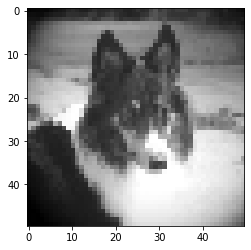


 44%|████▍     | 1104/2494 [00:33<01:16, 18.09it/s]

tensor([0.7348, 0.2652])


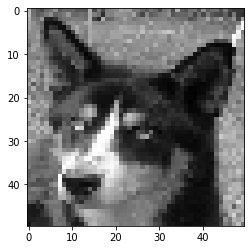


 45%|████▍     | 1110/2494 [00:33<01:05, 21.17it/s]

tensor([0.9980, 0.0020])


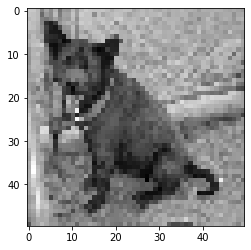


 45%|████▍     | 1115/2494 [00:34<00:58, 23.69it/s]

tensor([0.4398, 0.5602])


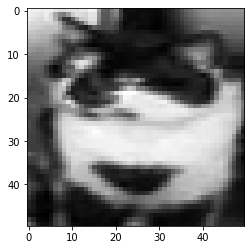


 45%|████▍     | 1119/2494 [00:34<00:56, 24.15it/s]

tensor([0.3825, 0.6175])


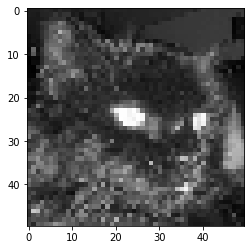


 45%|████▌     | 1125/2494 [00:34<00:49, 27.39it/s]

tensor([0.6799, 0.3201])


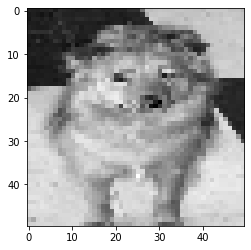


 45%|████▌     | 1129/2494 [00:34<00:49, 27.53it/s]

tensor([0.0592, 0.9408])


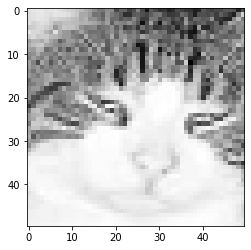


 46%|████▌     | 1135/2494 [00:34<00:45, 30.19it/s]

tensor([0.9980, 0.0020])


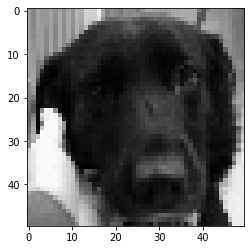


 46%|████▌     | 1142/2494 [00:34<00:40, 33.12it/s]

tensor([9.9999e-01, 8.1714e-06])


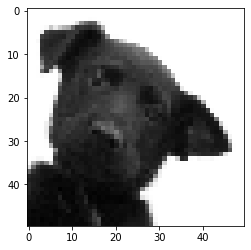


 46%|████▌     | 1149/2494 [00:34<00:38, 34.84it/s]

tensor([0.0983, 0.9017])


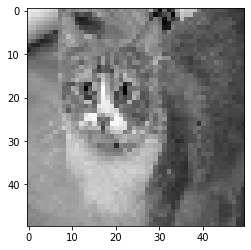


 46%|████▌     | 1153/2494 [00:35<00:41, 31.99it/s]

tensor([0.0027, 0.9973])


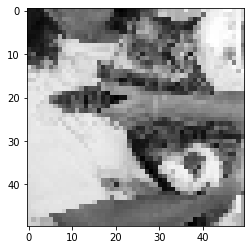

tensor([0.0025, 0.9975])


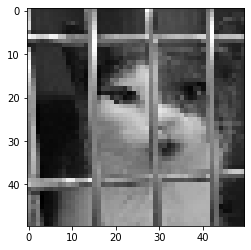


 46%|████▋     | 1157/2494 [00:35<01:00, 22.02it/s]

tensor([0.3532, 0.6468])


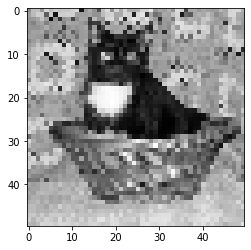


 47%|████▋     | 1161/2494 [00:35<00:57, 23.02it/s]

tensor([0.4364, 0.5636])


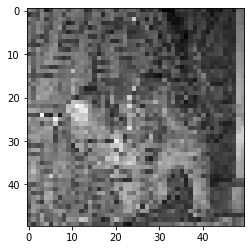


 47%|████▋     | 1165/2494 [00:35<00:56, 23.51it/s]

tensor([0.0459, 0.9541])


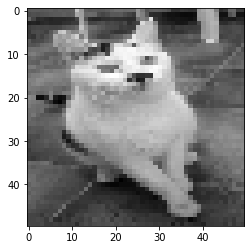


 47%|████▋     | 1170/2494 [00:35<00:51, 25.71it/s]

tensor([0.9537, 0.0463])


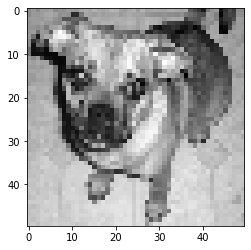


 47%|████▋     | 1173/2494 [00:36<00:54, 24.39it/s]

tensor([0.8406, 0.1594])


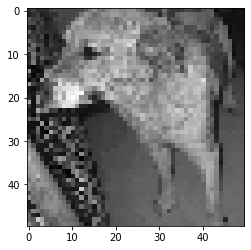


 47%|████▋     | 1176/2494 [00:36<00:56, 23.32it/s]

tensor([0.9990, 0.0010])


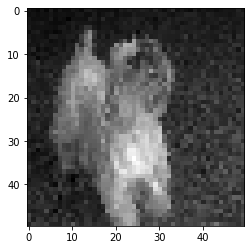


 47%|████▋     | 1180/2494 [00:36<00:54, 24.13it/s]

tensor([0.8651, 0.1349])


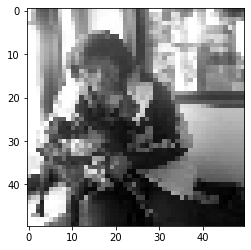


 48%|████▊     | 1185/2494 [00:36<00:48, 26.74it/s]

tensor([0.0453, 0.9547])


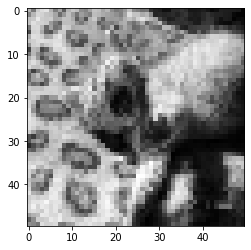


 48%|████▊     | 1189/2494 [00:36<00:48, 26.79it/s]

tensor([0.6344, 0.3656])


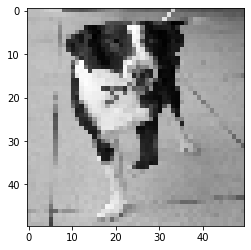

tensor([0.9980, 0.0020])


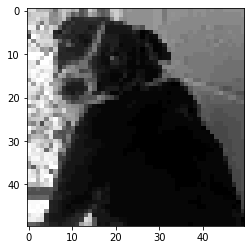


 48%|████▊     | 1192/2494 [00:36<01:16, 17.06it/s]

tensor([0.3986, 0.6014])


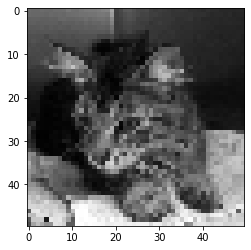


 48%|████▊     | 1196/2494 [00:37<01:06, 19.52it/s]

tensor([7.7117e-04, 9.9923e-01])


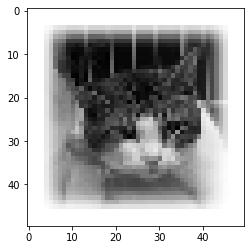


 48%|████▊     | 1199/2494 [00:37<01:03, 20.29it/s]

tensor([0.0497, 0.9503])


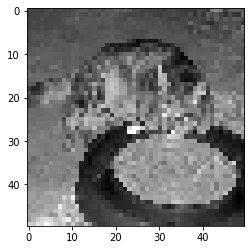


 48%|████▊     | 1204/2494 [00:37<00:55, 23.36it/s]

tensor([0.1740, 0.8260])


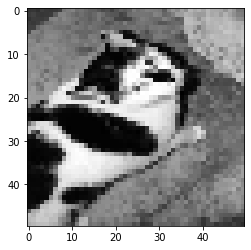


 48%|████▊     | 1208/2494 [00:37<00:52, 24.72it/s]

tensor([0.8653, 0.1347])


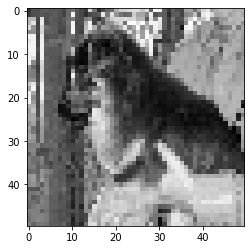


 49%|████▊     | 1211/2494 [00:37<00:54, 23.70it/s]

tensor([0.4077, 0.5923])


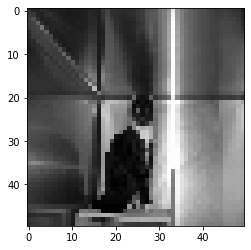


 49%|████▉     | 1216/2494 [00:37<00:48, 26.47it/s]

tensor([0.2747, 0.7253])


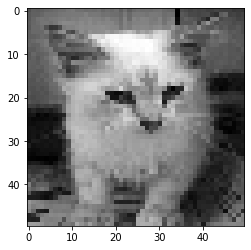


 49%|████▉     | 1220/2494 [00:37<00:46, 27.12it/s]

tensor([0.0295, 0.9705])


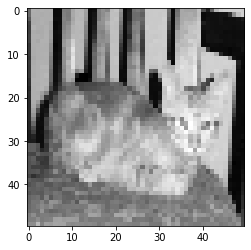


 49%|████▉     | 1225/2494 [00:38<00:43, 29.32it/s]

tensor([0.9822, 0.0178])


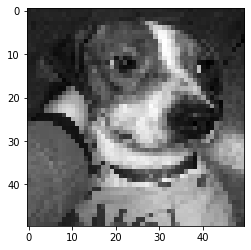


 49%|████▉     | 1229/2494 [00:38<00:43, 29.25it/s]

tensor([1.0000e+00, 3.2387e-08])


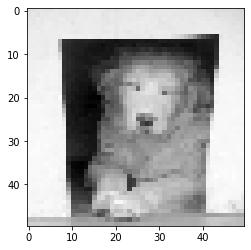


 50%|████▉     | 1239/2494 [00:38<00:35, 35.24it/s]

tensor([0.0385, 0.9615])


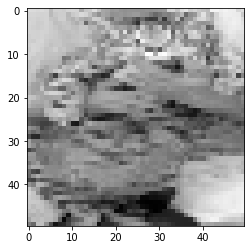

tensor([0.0693, 0.9307])


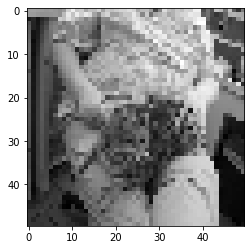


 50%|████▉     | 1244/2494 [00:38<00:50, 24.82it/s]

tensor([0.6807, 0.3193])


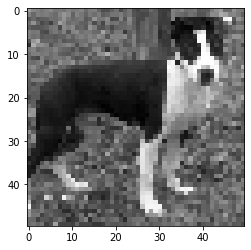

tensor([0.9333, 0.0667])


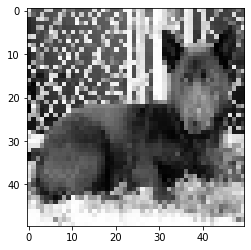


 50%|█████     | 1248/2494 [00:38<01:00, 20.46it/s]

tensor([1.0000e+00, 1.5032e-08])


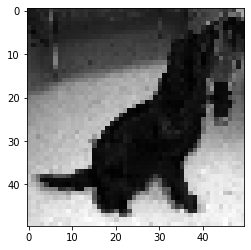


 50%|█████     | 1253/2494 [00:39<00:52, 23.53it/s]

tensor([0.9609, 0.0391])


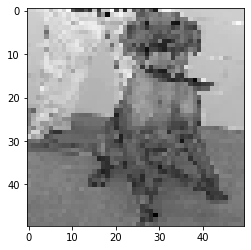


 50%|█████     | 1257/2494 [00:39<00:49, 25.05it/s]

tensor([0.1389, 0.8611])


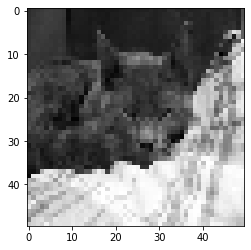

tensor([0.6467, 0.3533])


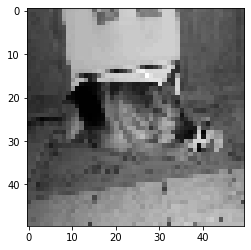


 51%|█████     | 1261/2494 [00:39<00:59, 20.86it/s]

tensor([0.4977, 0.5023])


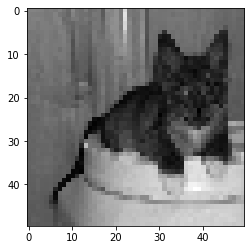

tensor([0.0016, 0.9984])


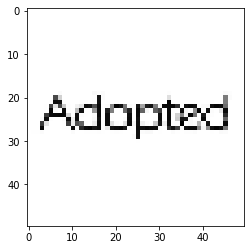


 51%|█████     | 1264/2494 [00:39<01:13, 16.72it/s]

tensor([0.9958, 0.0042])


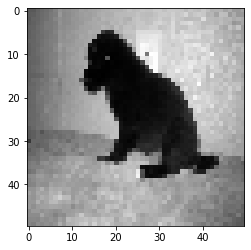


 51%|█████     | 1268/2494 [00:39<01:03, 19.18it/s]

tensor([0.3494, 0.6506])


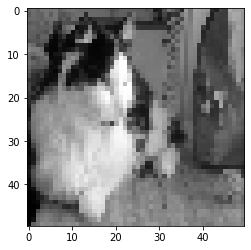


 51%|█████     | 1271/2494 [00:40<01:05, 18.69it/s]

tensor([0.9796, 0.0204])


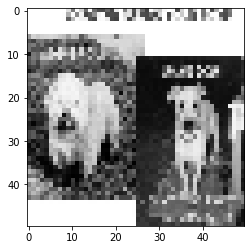


 51%|█████     | 1274/2494 [00:40<01:01, 19.73it/s]

tensor([0.9364, 0.0636])


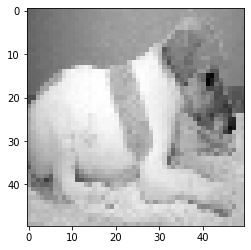


 51%|█████     | 1278/2494 [00:40<00:55, 21.88it/s]

tensor([1.0000e+00, 2.1420e-07])


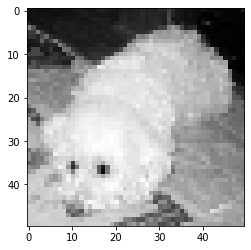


 51%|█████▏    | 1281/2494 [00:40<00:55, 21.94it/s]

tensor([0.9987, 0.0013])


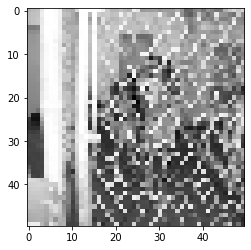


 52%|█████▏    | 1286/2494 [00:40<00:48, 24.83it/s]

tensor([5.8313e-04, 9.9942e-01])


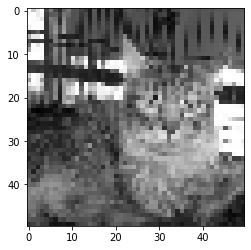


 52%|█████▏    | 1292/2494 [00:40<00:42, 28.47it/s]

tensor([0.0536, 0.9464])


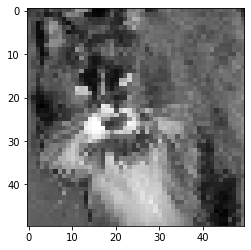


 52%|█████▏    | 1297/2494 [00:40<00:39, 30.52it/s]

tensor([0.0019, 0.9981])


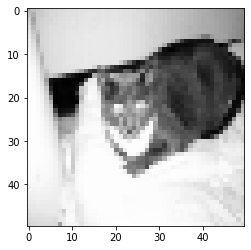


 52%|█████▏    | 1303/2494 [00:40<00:35, 33.79it/s]

tensor([1.0000e+00, 1.7390e-08])


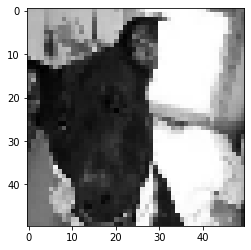


 53%|█████▎    | 1310/2494 [00:41<00:31, 37.84it/s]

tensor([0.9986, 0.0014])


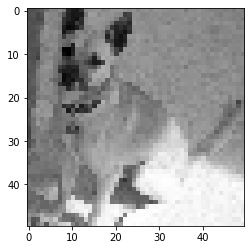


 53%|█████▎    | 1315/2494 [00:41<00:31, 37.43it/s]

tensor([0.7196, 0.2804])


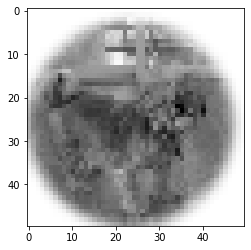

tensor([1.0000e+00, 1.0181e-07])


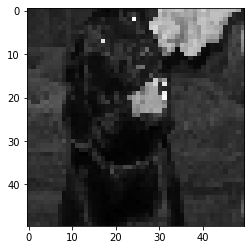


 53%|█████▎    | 1320/2494 [00:41<00:43, 26.73it/s]

tensor([0.7806, 0.2194])


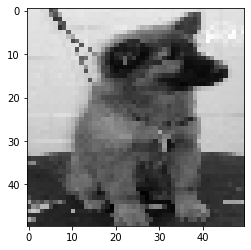


 53%|█████▎    | 1324/2494 [00:41<00:42, 27.53it/s]

tensor([0.3820, 0.6180])


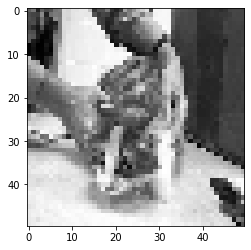


 53%|█████▎    | 1333/2494 [00:41<00:34, 33.24it/s]

tensor([0.5605, 0.4395])


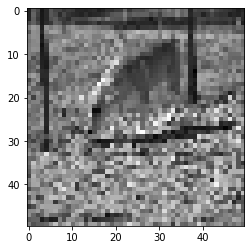


 54%|█████▍    | 1343/2494 [00:41<00:29, 39.48it/s]

tensor([0.2266, 0.7734])


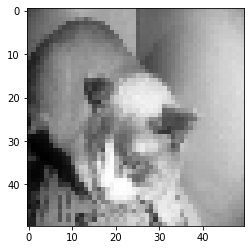


 54%|█████▍    | 1357/2494 [00:42<00:23, 47.91it/s]

tensor([0.9746, 0.0254])


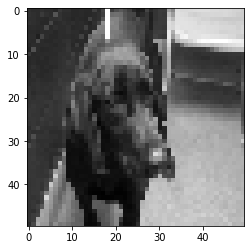


 55%|█████▍    | 1364/2494 [00:42<00:23, 48.67it/s]

tensor([0.2459, 0.7541])


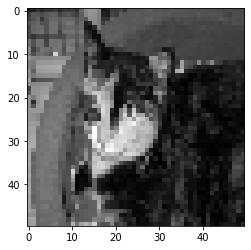


 55%|█████▌    | 1376/2494 [00:42<00:20, 55.70it/s]

tensor([0.1502, 0.8498])


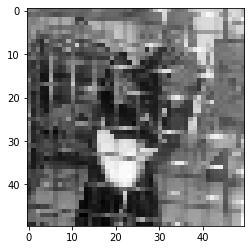


 56%|█████▌    | 1391/2494 [00:42<00:17, 64.07it/s]

tensor([0.0052, 0.9948])


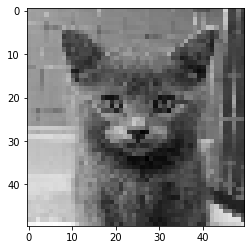


 56%|█████▌    | 1400/2494 [00:42<00:16, 64.50it/s]

tensor([0.0300, 0.9700])


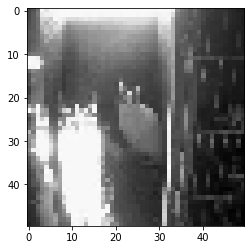

tensor([1.6020e-04, 9.9984e-01])


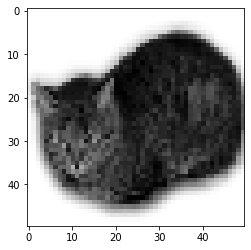


 56%|█████▋    | 1408/2494 [00:42<00:22, 48.47it/s]

tensor([0.9733, 0.0267])


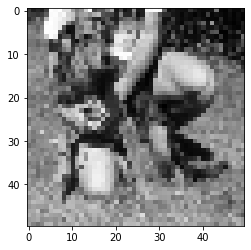

tensor([0.0706, 0.9294])


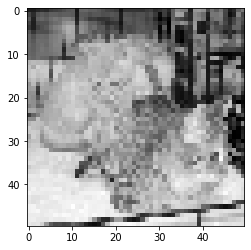

tensor([0.1987, 0.8013])


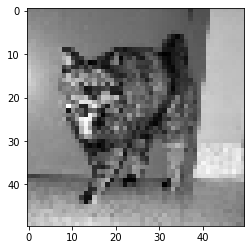


 57%|█████▋    | 1415/2494 [00:43<00:35, 30.71it/s]

tensor([0.9976, 0.0024])


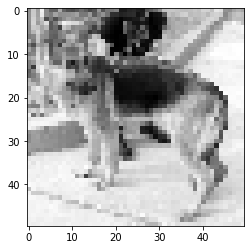

tensor([0.9525, 0.0475])


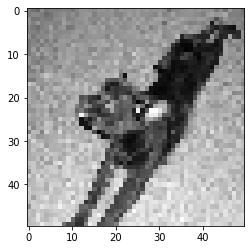


 57%|█████▋    | 1420/2494 [00:43<00:41, 25.69it/s]

tensor([1.9305e-04, 9.9981e-01])


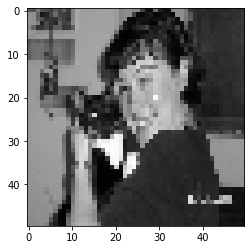


 57%|█████▋    | 1424/2494 [00:43<00:40, 26.58it/s]

tensor([9.9960e-01, 4.0104e-04])


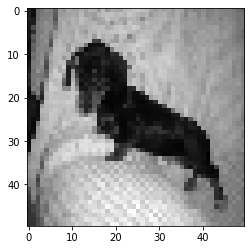


 57%|█████▋    | 1428/2494 [00:43<00:39, 27.22it/s]

tensor([0.9951, 0.0049])


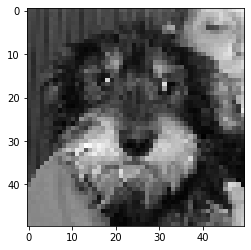


 57%|█████▋    | 1433/2494 [00:44<00:35, 29.69it/s]

tensor([0.2921, 0.7079])


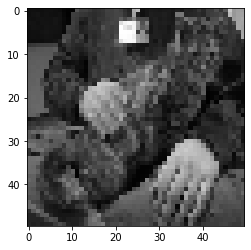


 58%|█████▊    | 1437/2494 [00:44<00:35, 29.66it/s]

tensor([0.5226, 0.4774])


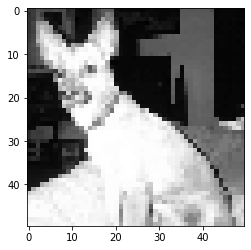


 58%|█████▊    | 1441/2494 [00:44<00:35, 29.80it/s]

tensor([0.3821, 0.6179])


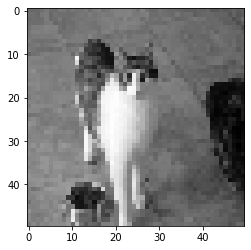


 58%|█████▊    | 1447/2494 [00:44<00:31, 33.17it/s]

tensor([0.0663, 0.9337])


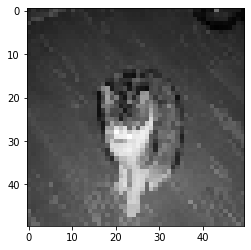


 58%|█████▊    | 1451/2494 [00:44<00:34, 29.87it/s]

tensor([0.3809, 0.6191])


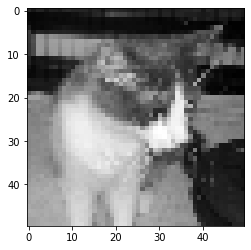

tensor([0.9978, 0.0022])


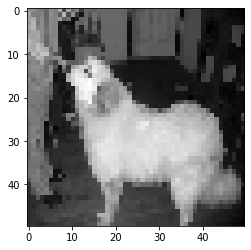


 58%|█████▊    | 1455/2494 [00:44<00:43, 23.95it/s]

tensor([0.0044, 0.9956])


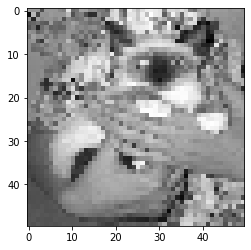


 58%|█████▊    | 1458/2494 [00:45<00:43, 23.94it/s]

tensor([0.0060, 0.9940])


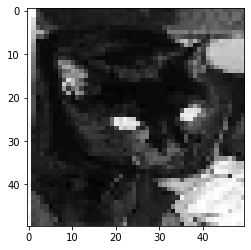


 59%|█████▉    | 1472/2494 [00:45<00:33, 30.95it/s]

tensor([0.9794, 0.0206])


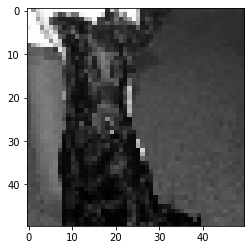


 59%|█████▉    | 1477/2494 [00:45<00:30, 33.06it/s]

tensor([0.9785, 0.0215])


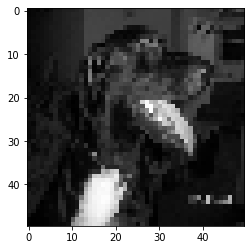


 59%|█████▉    | 1482/2494 [00:45<00:29, 34.23it/s]

tensor([7.1433e-04, 9.9929e-01])


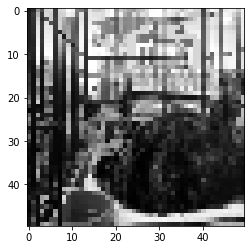


 60%|█████▉    | 1487/2494 [00:45<00:28, 35.16it/s]

tensor([0.7479, 0.2521])


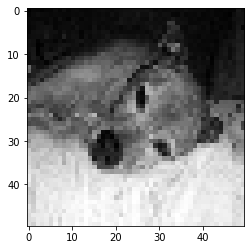

tensor([0.2877, 0.7123])


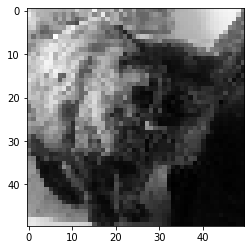


 60%|█████▉    | 1492/2494 [00:45<00:34, 28.89it/s]

tensor([0.0172, 0.9828])


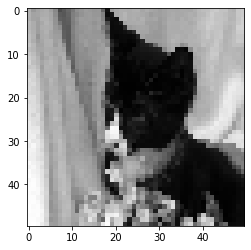


 60%|█████▉    | 1496/2494 [00:45<00:33, 29.46it/s]

tensor([0.1726, 0.8274])


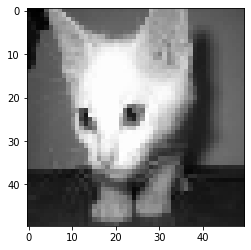

tensor([0.1282, 0.8718])


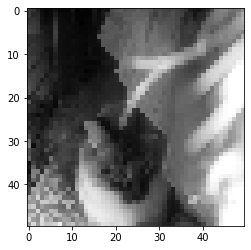


 60%|██████    | 1500/2494 [00:46<00:44, 22.47it/s]

tensor([9.9998e-01, 1.5586e-05])


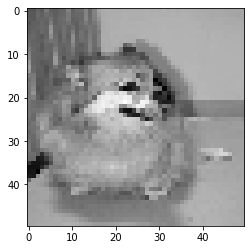


 60%|██████    | 1503/2494 [00:46<00:43, 22.74it/s]

tensor([0.0249, 0.9751])


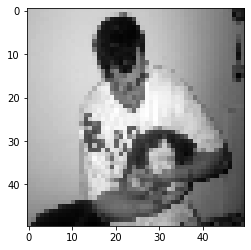


 61%|██████    | 1509/2494 [00:46<00:36, 26.82it/s]

tensor([0.0107, 0.9893])


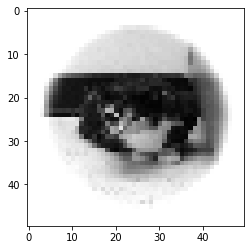


 61%|██████    | 1513/2494 [00:46<00:34, 28.06it/s]

tensor([9.9977e-01, 2.2956e-04])


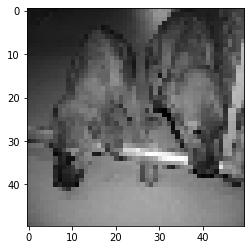


 61%|██████    | 1519/2494 [00:46<00:30, 31.66it/s]

tensor([0.7399, 0.2601])


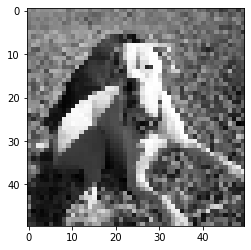


 61%|██████    | 1524/2494 [00:46<00:29, 32.95it/s]

tensor([0.6603, 0.3397])


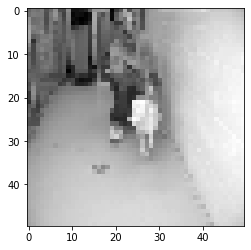


 61%|██████▏   | 1528/2494 [00:46<00:30, 31.26it/s]

tensor([1.0000e+00, 1.5877e-07])


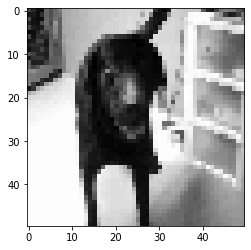


 62%|██████▏   | 1537/2494 [00:47<00:26, 36.63it/s]

tensor([0.0157, 0.9843])


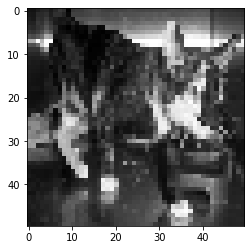

tensor([0.0124, 0.9876])


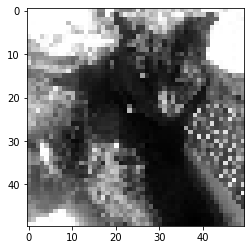


 62%|██████▏   | 1542/2494 [00:47<00:33, 28.05it/s]

tensor([0.4480, 0.5520])


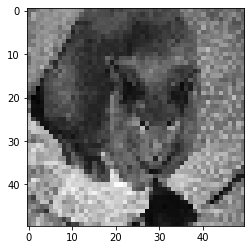


 62%|██████▏   | 1549/2494 [00:47<00:31, 30.00it/s]

tensor([6.7250e-05, 9.9993e-01])


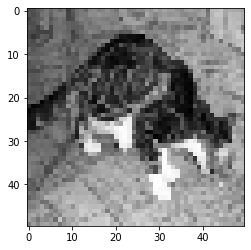


 62%|██████▏   | 1557/2494 [00:47<00:26, 34.73it/s]

tensor([9.9914e-01, 8.6167e-04])


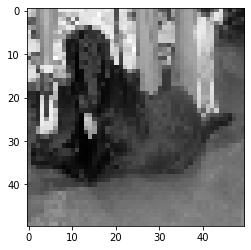

tensor([9.9930e-01, 7.0289e-04])


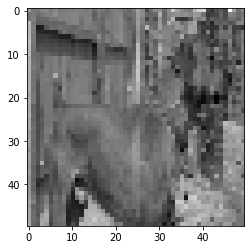


 63%|██████▎   | 1562/2494 [00:48<00:32, 28.63it/s]

tensor([0.0012, 0.9988])


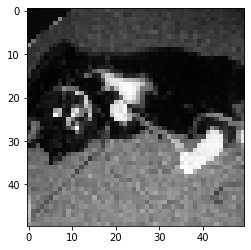


 63%|██████▎   | 1566/2494 [00:48<00:31, 29.18it/s]

tensor([0.1937, 0.8063])


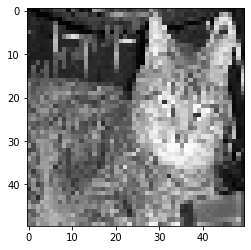


 63%|██████▎   | 1570/2494 [00:48<00:31, 29.80it/s]

tensor([0.0040, 0.9960])


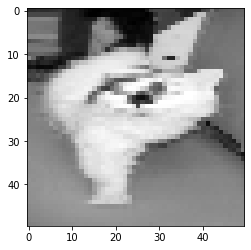


 63%|██████▎   | 1578/2494 [00:48<00:26, 35.03it/s]

tensor([0.9927, 0.0073])


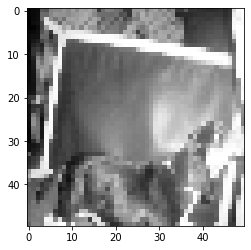

tensor([9.9996e-01, 3.6358e-05])


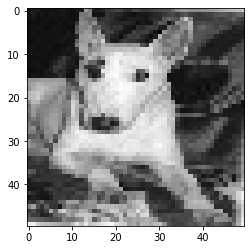


 63%|██████▎   | 1583/2494 [00:48<00:32, 28.34it/s]

tensor([0.5538, 0.4462])


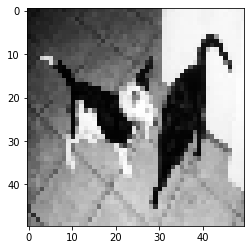

tensor([0.9989, 0.0011])


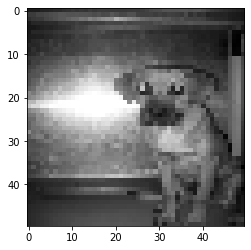


 64%|██████▎   | 1587/2494 [00:48<00:39, 22.89it/s]

tensor([0.0649, 0.9351])


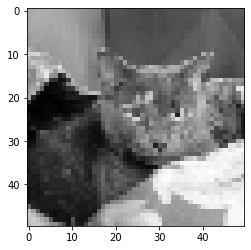


 64%|██████▍   | 1590/2494 [00:49<00:42, 21.33it/s]

tensor([0.9022, 0.0978])


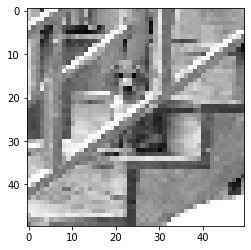

tensor([0.0159, 0.9841])


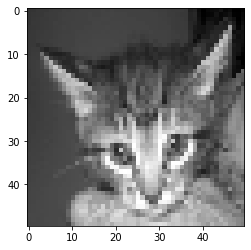

tensor([0.9250, 0.0750])


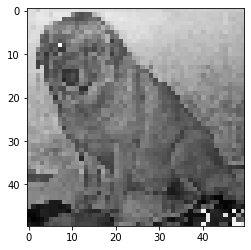


 64%|██████▍   | 1593/2494 [00:49<01:02, 14.44it/s]

tensor([0.8181, 0.1819])


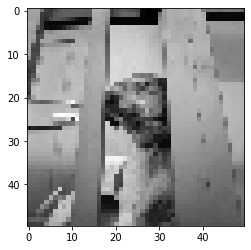


 64%|██████▍   | 1606/2494 [00:49<00:45, 19.34it/s]

tensor([0.9649, 0.0351])


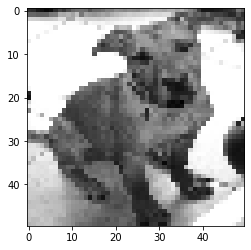

tensor([0.9777, 0.0223])


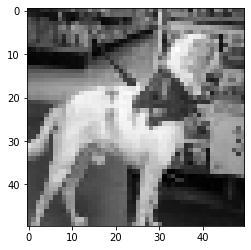


 65%|██████▍   | 1611/2494 [00:49<00:44, 19.70it/s]

tensor([0.7559, 0.2441])


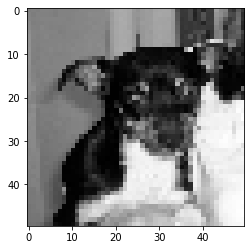

tensor([0.1296, 0.8704])


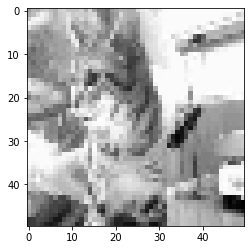


 65%|██████▍   | 1615/2494 [00:50<00:47, 18.65it/s]

tensor([1.9280e-04, 9.9981e-01])


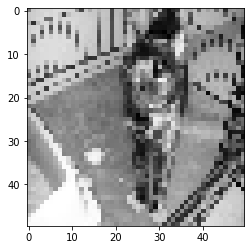


 65%|██████▍   | 1621/2494 [00:50<00:38, 22.63it/s]

tensor([0.0845, 0.9155])


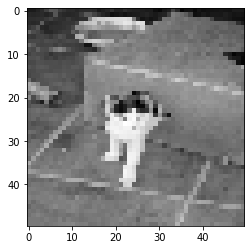


 65%|██████▌   | 1625/2494 [00:50<00:35, 24.61it/s]

tensor([1.2708e-04, 9.9987e-01])


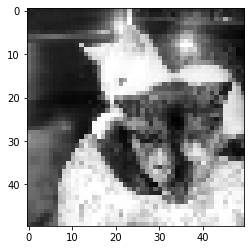


 65%|██████▌   | 1629/2494 [00:50<00:35, 24.70it/s]

tensor([0.0063, 0.9937])


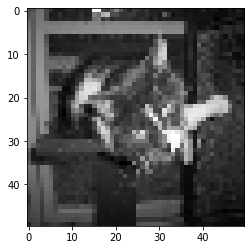


 66%|██████▌   | 1635/2494 [00:50<00:29, 28.77it/s]

tensor([0.9689, 0.0311])


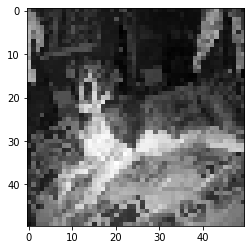


 66%|██████▌   | 1639/2494 [00:50<00:28, 29.52it/s]

tensor([0.9426, 0.0574])


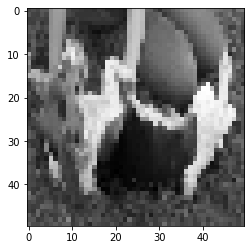


 66%|██████▋   | 1653/2494 [00:50<00:22, 37.45it/s]

tensor([0.2417, 0.7583])


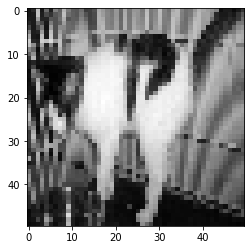

tensor([0.9023, 0.0977])


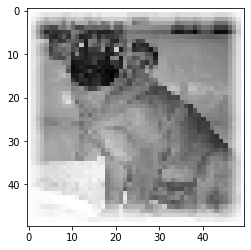


 67%|██████▋   | 1659/2494 [00:51<00:25, 32.27it/s]

tensor([0.0011, 0.9989])


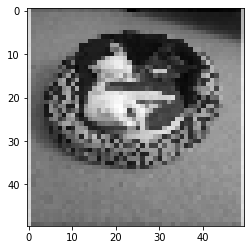

tensor([0.4765, 0.5235])


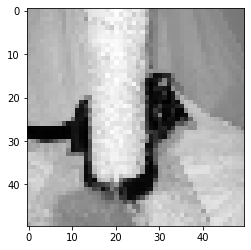

tensor([0.0827, 0.9173])


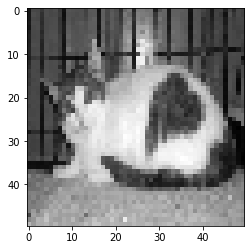

tensor([0.6282, 0.3718])


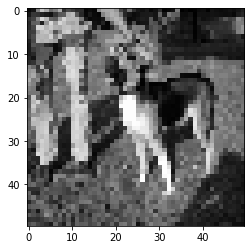


 67%|██████▋   | 1664/2494 [00:51<00:41, 19.79it/s]

tensor([0.0253, 0.9747])


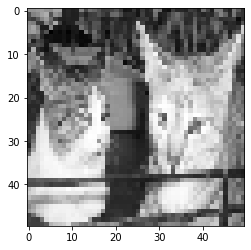

tensor([0.3007, 0.6993])


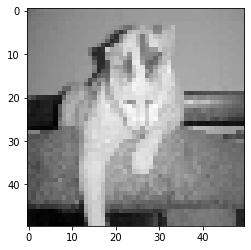


 67%|██████▋   | 1668/2494 [00:51<00:47, 17.32it/s]

tensor([0.0033, 0.9967])


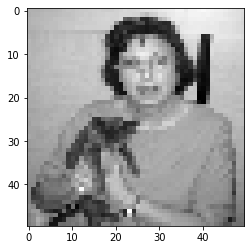


 67%|██████▋   | 1677/2494 [00:52<00:36, 22.19it/s]

tensor([0.1406, 0.8594])


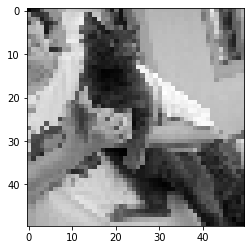


 67%|██████▋   | 1681/2494 [00:52<00:33, 24.38it/s]

tensor([0.1529, 0.8471])


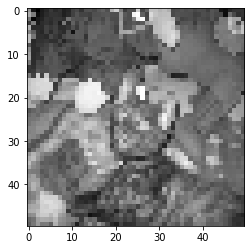


 68%|██████▊   | 1687/2494 [00:52<00:28, 28.42it/s]

tensor([0.0684, 0.9316])


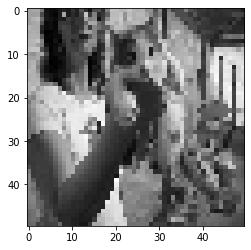


 68%|██████▊   | 1694/2494 [00:52<00:24, 33.06it/s]

tensor([0.8677, 0.1323])


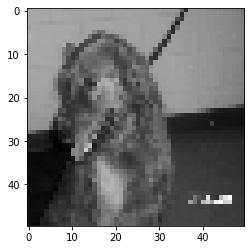

tensor([0.9944, 0.0056])


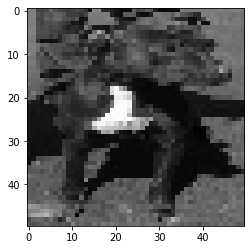


 68%|██████▊   | 1699/2494 [00:52<00:28, 27.47it/s]

tensor([0.7690, 0.2310])


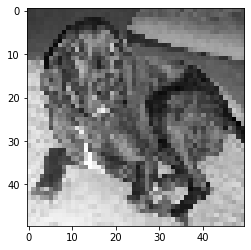


 68%|██████▊   | 1703/2494 [00:52<00:27, 28.41it/s]

tensor([0.2212, 0.7788])


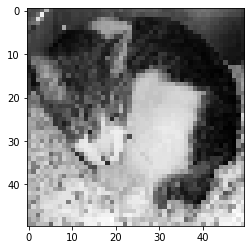

tensor([4.8799e-04, 9.9951e-01])


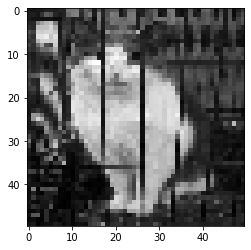


 68%|██████▊   | 1707/2494 [00:53<00:33, 23.32it/s]

tensor([0.9705, 0.0295])


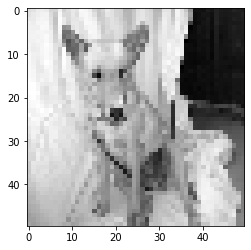


 69%|██████▊   | 1711/2494 [00:53<00:30, 25.30it/s]

tensor([0.8657, 0.1343])


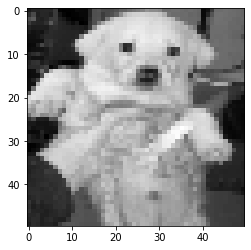


 69%|██████▉   | 1723/2494 [00:53<00:24, 31.26it/s]

tensor([0.9802, 0.0198])


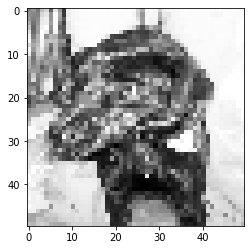


 70%|██████▉   | 1741/2494 [00:53<00:18, 40.03it/s]

tensor([9.9998e-01, 2.2980e-05])


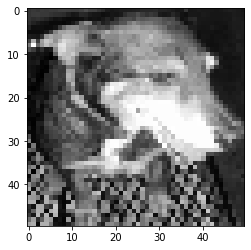

tensor([0.9695, 0.0305])


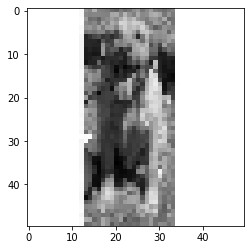


 70%|███████   | 1748/2494 [00:53<00:21, 35.15it/s]

tensor([0.0673, 0.9327])


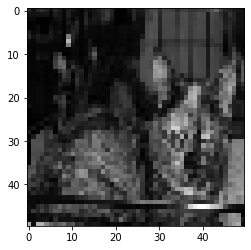

tensor([9.9951e-01, 4.8663e-04])


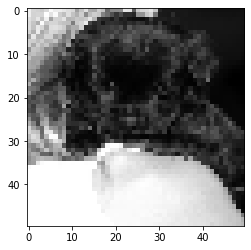

tensor([9.9937e-01, 6.2646e-04])


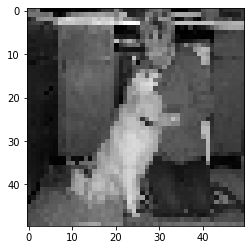

tensor([0.6248, 0.3752])


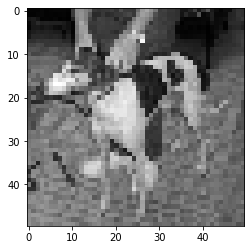


 70%|███████   | 1754/2494 [00:54<00:32, 22.66it/s]

tensor([0.0062, 0.9938])


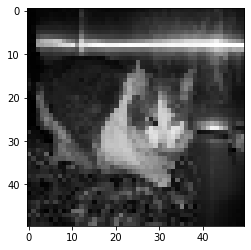

tensor([0.9860, 0.0140])


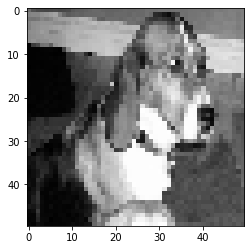


 71%|███████   | 1759/2494 [00:54<00:33, 22.01it/s]

tensor([0.2607, 0.7393])


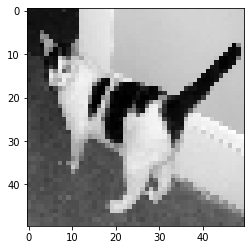


 71%|███████   | 1763/2494 [00:54<00:30, 24.17it/s]

tensor([7.7238e-05, 9.9992e-01])


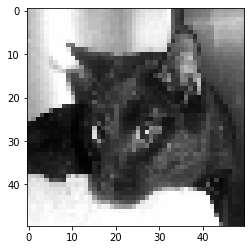

tensor([0.2429, 0.7571])


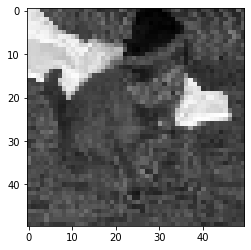

tensor([0.0501, 0.9499])


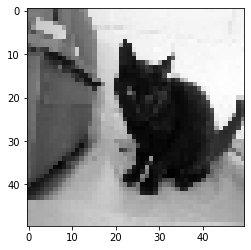


 71%|███████   | 1767/2494 [00:55<00:42, 17.06it/s]

tensor([1.1694e-04, 9.9988e-01])


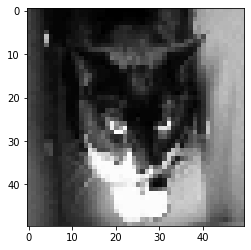


 71%|███████   | 1774/2494 [00:55<00:33, 21.44it/s]

tensor([0.0147, 0.9853])


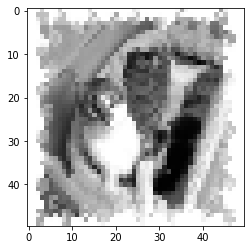

tensor([0.0722, 0.9278])


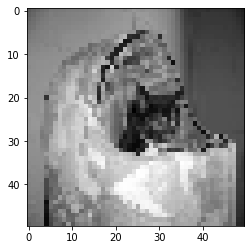


 71%|███████▏  | 1778/2494 [00:55<00:36, 19.58it/s]

tensor([0.0259, 0.9741])


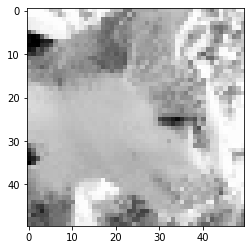


 71%|███████▏  | 1781/2494 [00:55<00:34, 20.73it/s]

tensor([0.5267, 0.4733])


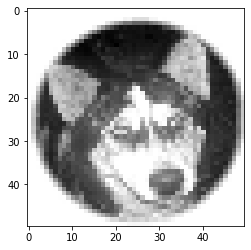


 72%|███████▏  | 1784/2494 [00:55<00:32, 21.64it/s]

tensor([0.8870, 0.1130])


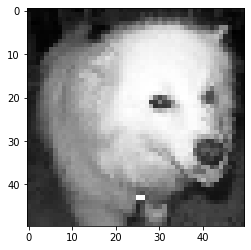


 72%|███████▏  | 1787/2494 [00:55<00:31, 22.41it/s]

tensor([0.4207, 0.5793])


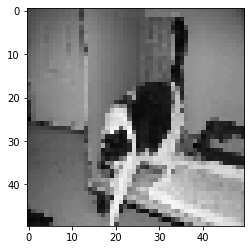


 72%|███████▏  | 1790/2494 [00:55<00:30, 22.85it/s]

tensor([0.9988, 0.0012])


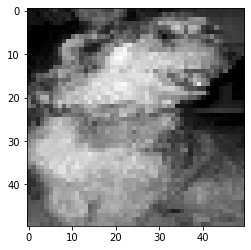


 72%|███████▏  | 1793/2494 [00:56<00:30, 23.23it/s]

tensor([0.3917, 0.6083])


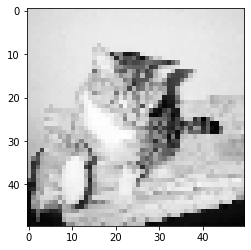


 72%|███████▏  | 1800/2494 [00:56<00:25, 26.84it/s]

tensor([0.7673, 0.2327])


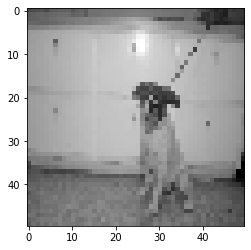


 72%|███████▏  | 1804/2494 [00:56<00:24, 28.17it/s]

tensor([0.9936, 0.0064])


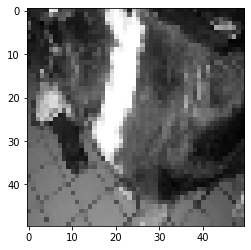


 72%|███████▏  | 1808/2494 [00:56<00:23, 29.06it/s]

tensor([0.0041, 0.9959])


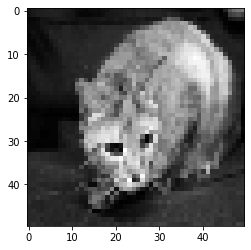


 73%|███████▎  | 1815/2494 [00:56<00:20, 33.68it/s]

tensor([0.9867, 0.0133])


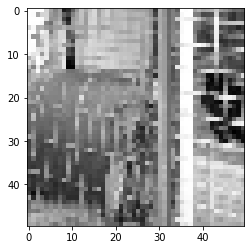


 73%|███████▎  | 1819/2494 [00:56<00:20, 33.14it/s]

tensor([0.7259, 0.2741])


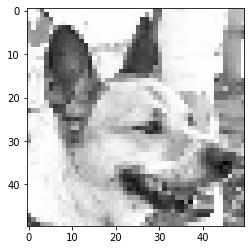


 74%|███████▎  | 1836/2494 [00:56<00:15, 42.22it/s]

tensor([0.0050, 0.9950])


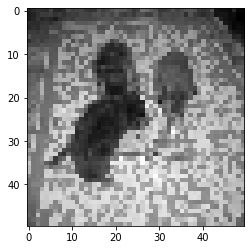

tensor([0.0040, 0.9960])


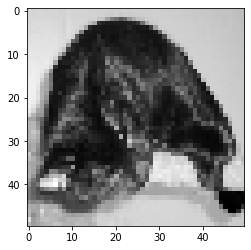


 74%|███████▍  | 1843/2494 [00:57<00:18, 36.09it/s]

tensor([0.9728, 0.0272])


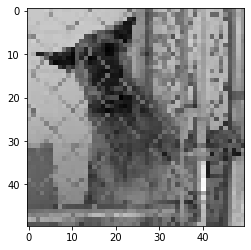

tensor([0.2702, 0.7298])


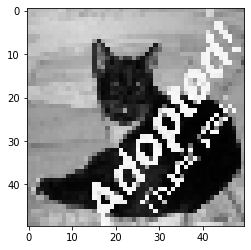


 74%|███████▍  | 1849/2494 [00:57<00:21, 29.48it/s]

tensor([0.9816, 0.0184])


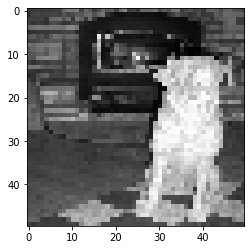


 74%|███████▍  | 1855/2494 [00:57<00:19, 32.07it/s]

tensor([0.5576, 0.4424])


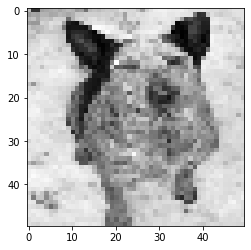


 75%|███████▍  | 1860/2494 [00:57<00:20, 30.26it/s]

tensor([0.6000, 0.4000])


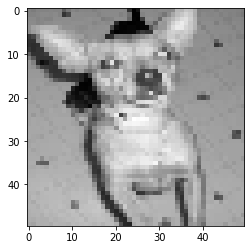

tensor([0.0012, 0.9988])


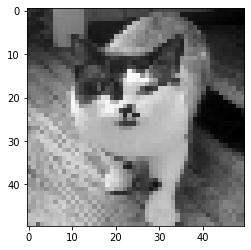


 75%|███████▍  | 1864/2494 [00:57<00:27, 22.69it/s]

tensor([1.0000e+00, 3.4852e-07])


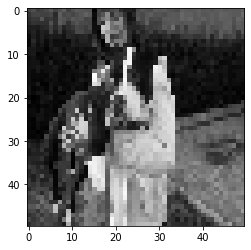


 75%|███████▍  | 1868/2494 [00:58<00:25, 24.32it/s]

tensor([0.0027, 0.9973])


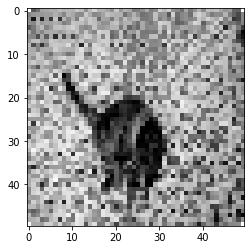


 75%|███████▌  | 1871/2494 [00:58<00:26, 23.81it/s]

tensor([0.2720, 0.7280])


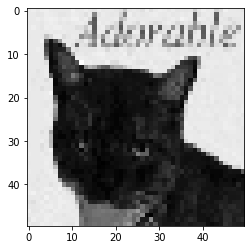


 75%|███████▌  | 1874/2494 [00:58<00:26, 23.73it/s]

tensor([0.0149, 0.9851])


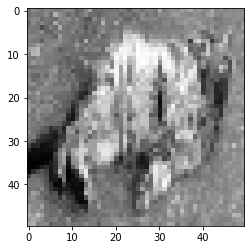

tensor([0.4451, 0.5549])


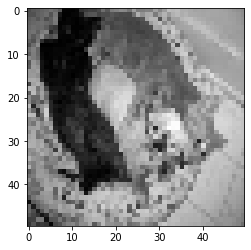


 75%|███████▌  | 1877/2494 [00:58<00:33, 18.35it/s]

tensor([0.7959, 0.2041])


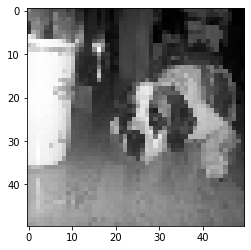

tensor([0.1884, 0.8116])


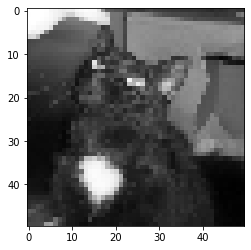


 75%|███████▌  | 1880/2494 [00:58<00:39, 15.68it/s]

tensor([0.8989, 0.1011])


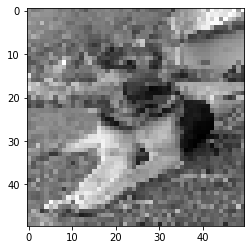


 76%|███████▌  | 1883/2494 [00:59<00:35, 17.13it/s]

tensor([0.5285, 0.4715])


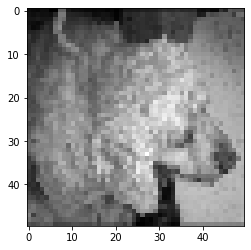


 76%|███████▌  | 1888/2494 [00:59<00:31, 19.44it/s]

tensor([0.5935, 0.4065])


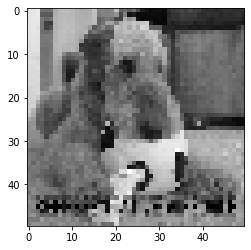


 76%|███████▌  | 1895/2494 [00:59<00:24, 24.04it/s]

tensor([0.3364, 0.6636])


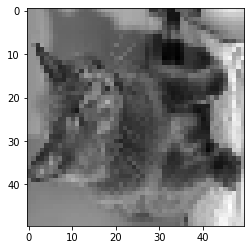


 76%|███████▌  | 1899/2494 [00:59<00:22, 25.89it/s]

tensor([1.2150e-05, 9.9999e-01])


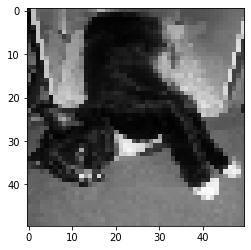

tensor([0.9982, 0.0018])


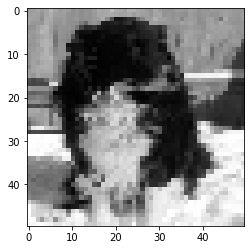


 76%|███████▋  | 1903/2494 [00:59<00:27, 21.89it/s]

tensor([0.9696, 0.0304])


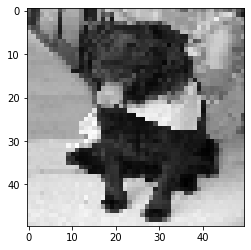


 77%|███████▋  | 1908/2494 [00:59<00:23, 25.20it/s]

tensor([0.0495, 0.9505])


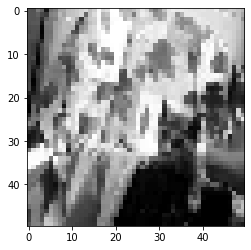


 77%|███████▋  | 1912/2494 [00:59<00:21, 26.52it/s]

tensor([0.0192, 0.9808])


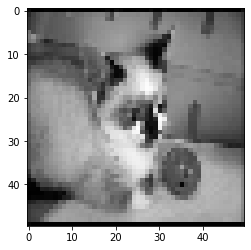

tensor([0.0640, 0.9360])


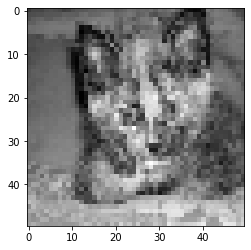


 77%|███████▋  | 1916/2494 [01:00<00:25, 22.34it/s]

tensor([0.7629, 0.2371])


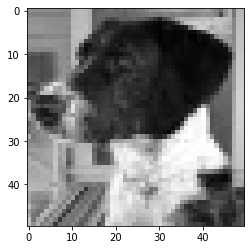


 77%|███████▋  | 1920/2494 [01:00<00:24, 23.91it/s]

tensor([0.3377, 0.6623])


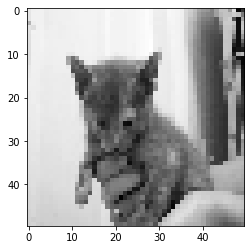


 77%|███████▋  | 1923/2494 [01:00<00:24, 23.70it/s]

tensor([0.4677, 0.5323])


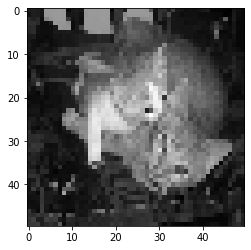


 77%|███████▋  | 1926/2494 [01:00<00:25, 22.00it/s]

tensor([0.9204, 0.0796])


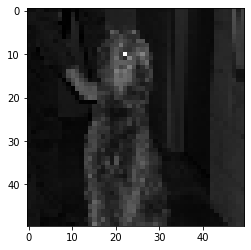


 77%|███████▋  | 1929/2494 [01:00<00:25, 22.56it/s]

tensor([5.8652e-04, 9.9941e-01])


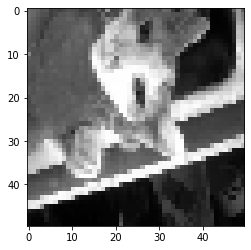


 78%|███████▊  | 1940/2494 [01:00<00:19, 28.76it/s]

tensor([0.7500, 0.2500])


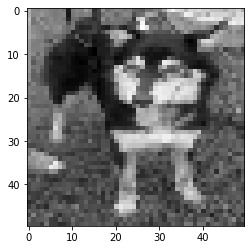

tensor([0.4770, 0.5230])


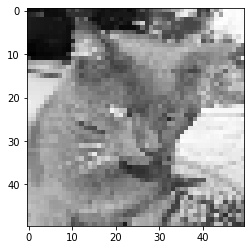


 78%|███████▊  | 1945/2494 [01:01<00:21, 25.36it/s]

tensor([0.9873, 0.0127])


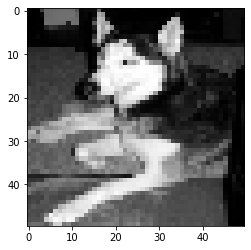


 78%|███████▊  | 1952/2494 [01:01<00:18, 30.09it/s]

tensor([0.9045, 0.0955])


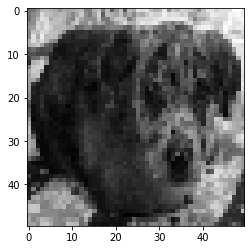


 78%|███████▊  | 1957/2494 [01:01<00:16, 32.23it/s]

tensor([0.7421, 0.2579])


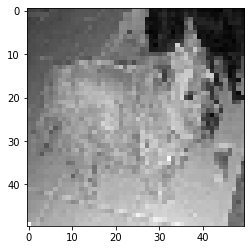

tensor([0.0436, 0.9564])


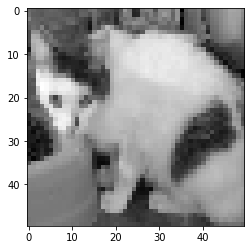


 79%|███████▊  | 1961/2494 [01:01<00:21, 24.71it/s]

tensor([0.9932, 0.0068])


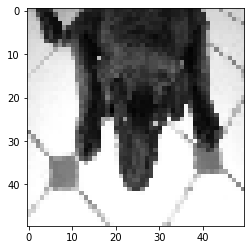


 79%|███████▉  | 1965/2494 [01:01<00:20, 26.04it/s]

tensor([0.9432, 0.0568])


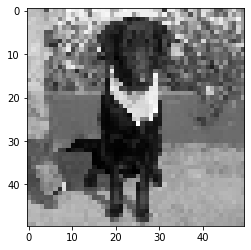

tensor([0.9960, 0.0040])


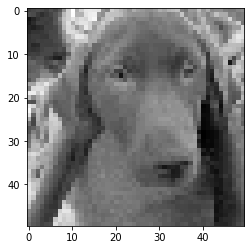


 79%|███████▉  | 1969/2494 [01:02<00:25, 20.62it/s]

tensor([0.9625, 0.0375])


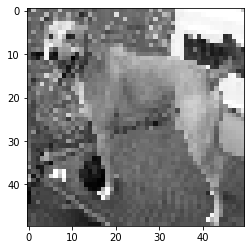


 79%|███████▉  | 1973/2494 [01:02<00:22, 23.08it/s]

tensor([0.9470, 0.0530])


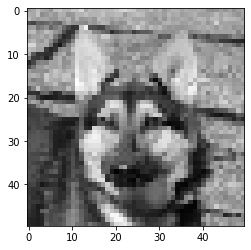


 79%|███████▉  | 1982/2494 [01:02<00:17, 28.79it/s]

tensor([0.1376, 0.8624])


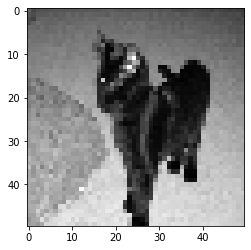

tensor([0.9411, 0.0589])


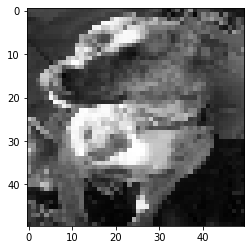


 80%|███████▉  | 1987/2494 [01:02<00:19, 25.67it/s]

tensor([0.0419, 0.9581])


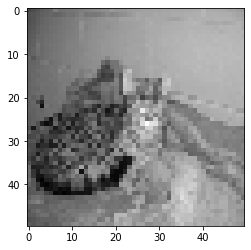


 80%|███████▉  | 1992/2494 [01:02<00:17, 28.57it/s]

tensor([0.0681, 0.9319])


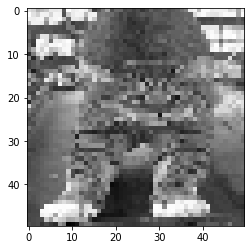


 80%|████████  | 1997/2494 [01:02<00:15, 31.12it/s]

tensor([0.0049, 0.9951])


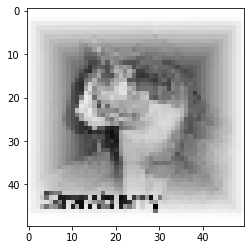


 80%|████████  | 2004/2494 [01:02<00:13, 35.57it/s]

tensor([0.9161, 0.0839])


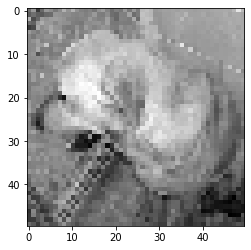

tensor([9.9938e-01, 6.1502e-04])


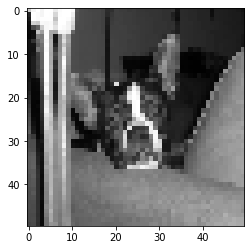


 81%|████████  | 2009/2494 [01:03<00:17, 28.51it/s]

tensor([0.9751, 0.0249])


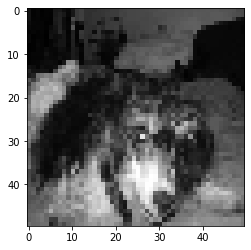


 81%|████████  | 2013/2494 [01:03<00:16, 28.38it/s]

tensor([0.9798, 0.0202])


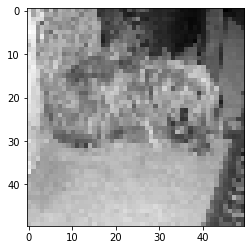

tensor([0.0018, 0.9982])


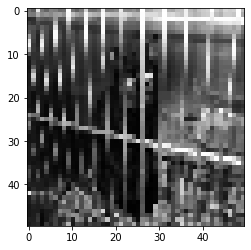

tensor([0.8584, 0.1416])


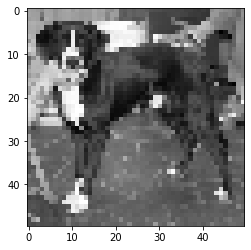


 81%|████████  | 2017/2494 [01:03<00:27, 17.19it/s]

tensor([0.9343, 0.0657])


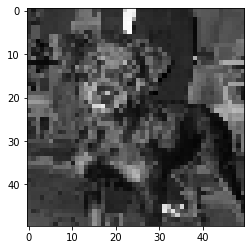


 81%|████████  | 2020/2494 [01:04<00:27, 17.51it/s]

tensor([0.6091, 0.3909])


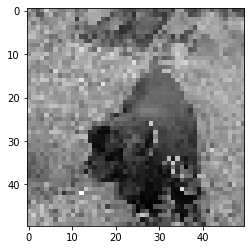


 81%|████████▏ | 2027/2494 [01:04<00:21, 21.50it/s]

tensor([0.0732, 0.9268])


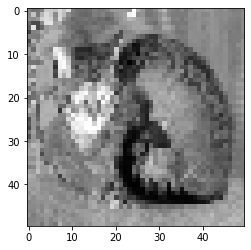


 82%|████████▏ | 2035/2494 [01:04<00:17, 26.34it/s]

tensor([0.0027, 0.9973])


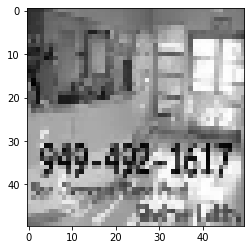

tensor([0.8440, 0.1560])


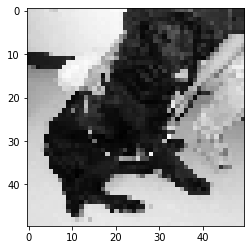


 82%|████████▏ | 2039/2494 [01:04<00:21, 21.27it/s]

tensor([3.7119e-04, 9.9963e-01])


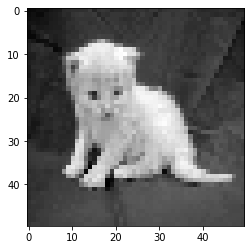

tensor([0.4189, 0.5811])


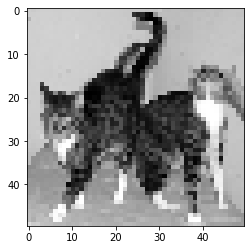


 82%|████████▏ | 2043/2494 [01:04<00:23, 18.90it/s]

tensor([0.5384, 0.4616])


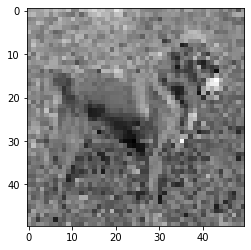


 82%|████████▏ | 2046/2494 [01:04<00:22, 19.60it/s]

tensor([0.6080, 0.3920])


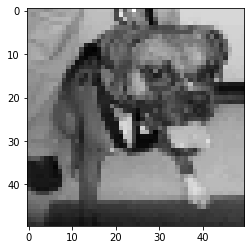


 82%|████████▏ | 2051/2494 [01:05<00:20, 21.38it/s]

tensor([0.6520, 0.3480])


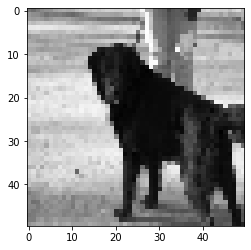

tensor([1.0232e-04, 9.9990e-01])


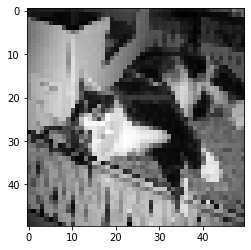


 82%|████████▏ | 2054/2494 [01:05<00:26, 16.52it/s]

tensor([0.1465, 0.8535])


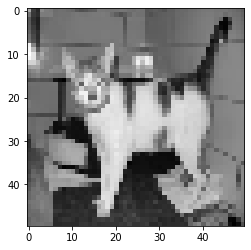


 83%|████████▎ | 2063/2494 [01:05<00:20, 21.23it/s]

tensor([0.9863, 0.0137])


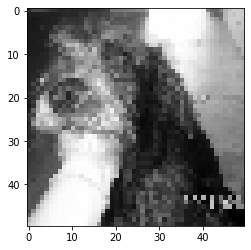

tensor([0.9773, 0.0227])


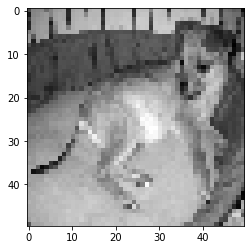


 83%|████████▎ | 2067/2494 [01:05<00:22, 18.97it/s]

tensor([0.1181, 0.8819])


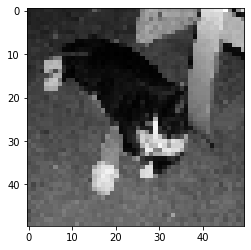

tensor([0.0053, 0.9947])


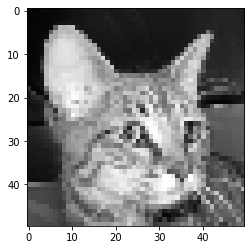


 83%|████████▎ | 2070/2494 [01:06<00:27, 15.41it/s]

tensor([0.0628, 0.9372])


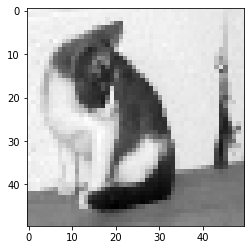


 83%|████████▎ | 2074/2494 [01:06<00:23, 17.60it/s]

tensor([9.9935e-01, 6.5486e-04])


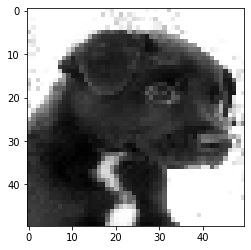


 84%|████████▎ | 2086/2494 [01:06<00:17, 22.87it/s]

tensor([0.9765, 0.0235])


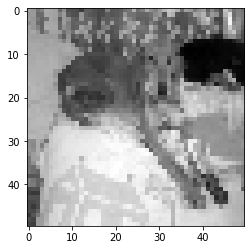

tensor([0.3437, 0.6563])


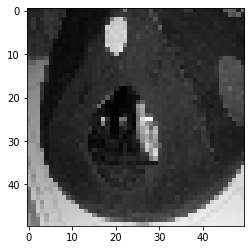


 84%|████████▍ | 2090/2494 [01:06<00:21, 19.03it/s]

tensor([0.9835, 0.0165])


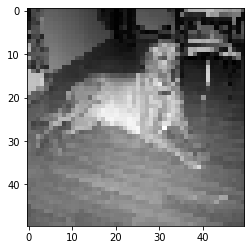


 84%|████████▍ | 2098/2494 [01:06<00:16, 23.80it/s]

tensor([0.0091, 0.9909])


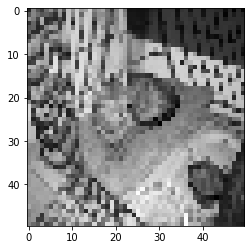


 84%|████████▍ | 2104/2494 [01:07<00:14, 27.67it/s]

tensor([0.7285, 0.2715])


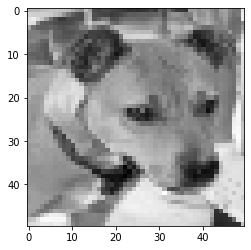


 85%|████████▍ | 2109/2494 [01:07<00:13, 28.97it/s]

tensor([6.8993e-04, 9.9931e-01])


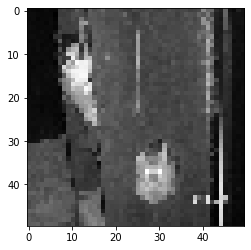


 85%|████████▍ | 2118/2494 [01:07<00:11, 34.04it/s]

tensor([0.9593, 0.0407])


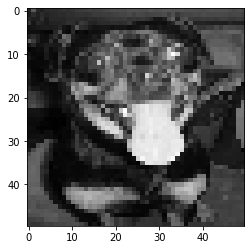


 85%|████████▌ | 2123/2494 [01:07<00:11, 33.36it/s]

tensor([0.4402, 0.5598])


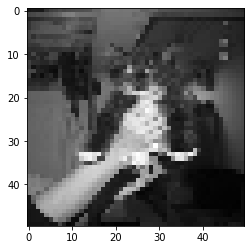

tensor([9.9912e-01, 8.7708e-04])


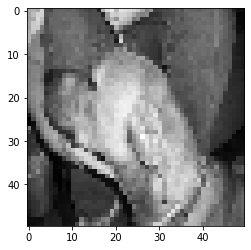


 85%|████████▌ | 2128/2494 [01:07<00:13, 26.81it/s]

tensor([0.9969, 0.0031])


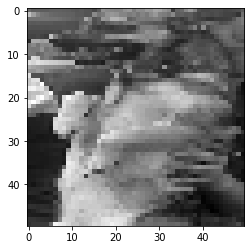


 85%|████████▌ | 2132/2494 [01:07<00:12, 27.96it/s]

tensor([0.0154, 0.9846])


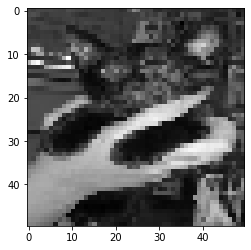

tensor([0.2871, 0.7129])


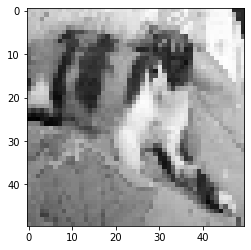


 86%|████████▌ | 2136/2494 [01:08<00:15, 23.07it/s]

tensor([0.0835, 0.9165])


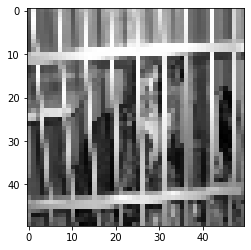


 86%|████████▌ | 2139/2494 [01:08<00:16, 21.62it/s]

tensor([0.7799, 0.2201])


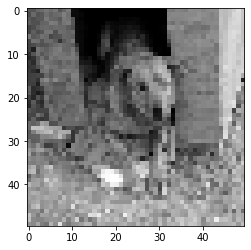


 86%|████████▌ | 2149/2494 [01:08<00:12, 27.30it/s]

tensor([0.0047, 0.9953])


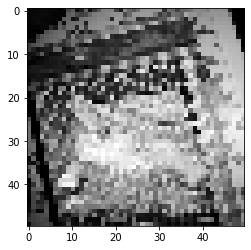


 86%|████████▋ | 2153/2494 [01:08<00:12, 28.23it/s]

tensor([0.3505, 0.6495])


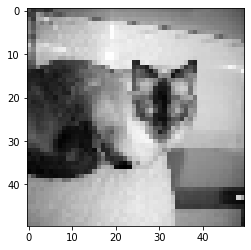


 86%|████████▋ | 2157/2494 [01:08<00:11, 28.76it/s]

tensor([0.9364, 0.0636])


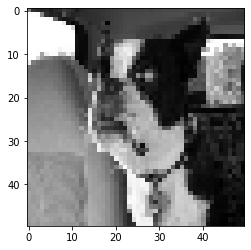


 87%|████████▋ | 2161/2494 [01:08<00:11, 29.15it/s]

tensor([0.0062, 0.9938])


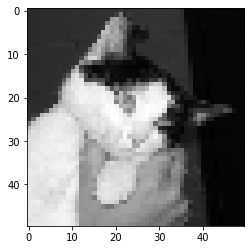


 87%|████████▋ | 2165/2494 [01:08<00:11, 29.87it/s]

tensor([0.0338, 0.9662])


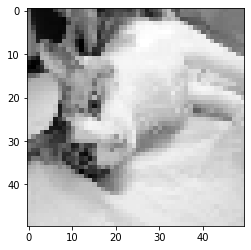


 87%|████████▋ | 2169/2494 [01:09<00:10, 30.34it/s]

tensor([0.1744, 0.8256])


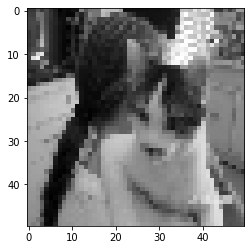


 87%|████████▋ | 2177/2494 [01:09<00:08, 35.62it/s]

tensor([0.0759, 0.9241])


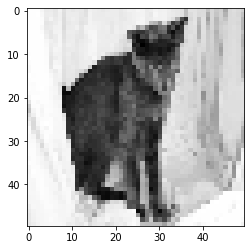

tensor([0.7456, 0.2544])


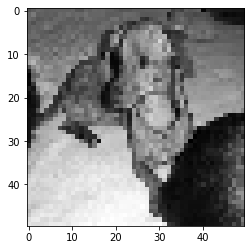


 87%|████████▋ | 2182/2494 [01:09<00:10, 29.13it/s]

tensor([9.9912e-01, 8.8020e-04])


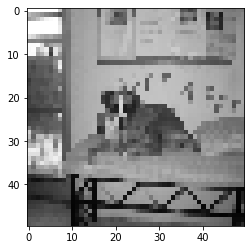


 88%|████████▊ | 2191/2494 [01:09<00:08, 35.17it/s]

tensor([0.9426, 0.0574])


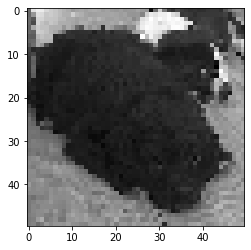


 88%|████████▊ | 2196/2494 [01:09<00:08, 33.70it/s]

tensor([0.1898, 0.8102])


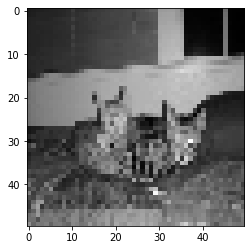

tensor([0.5506, 0.4494])


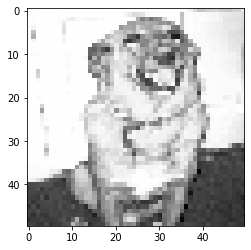


 88%|████████▊ | 2201/2494 [01:09<00:10, 28.32it/s]

tensor([0.5707, 0.4293])


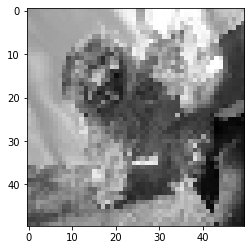


 88%|████████▊ | 2205/2494 [01:10<00:09, 29.26it/s]

tensor([0.4302, 0.5698])


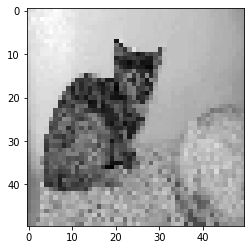


 89%|████████▊ | 2209/2494 [01:10<00:09, 29.95it/s]

tensor([0.4947, 0.5053])


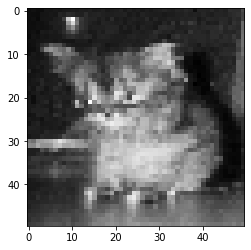


 89%|████████▊ | 2213/2494 [01:10<00:09, 30.41it/s]

tensor([0.0458, 0.9542])


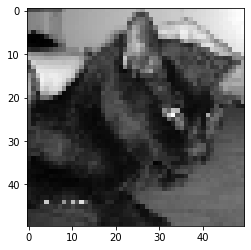

tensor([0.9830, 0.0170])


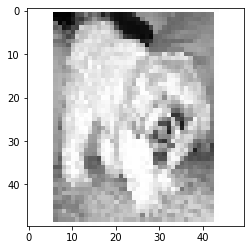

tensor([0.9833, 0.0167])


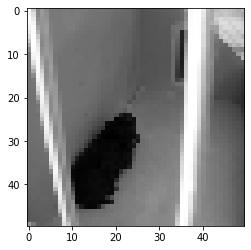


 89%|████████▉ | 2217/2494 [01:10<00:13, 19.99it/s]

tensor([0.7743, 0.2257])


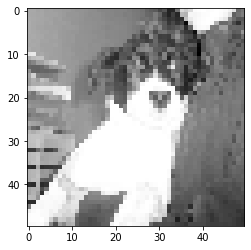


 89%|████████▉ | 2230/2494 [01:10<00:10, 26.18it/s]

tensor([0.8629, 0.1371])


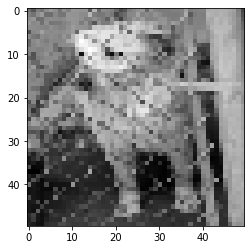

tensor([0.0012, 0.9988])


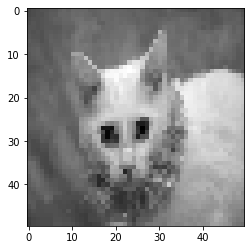


 90%|████████▉ | 2235/2494 [01:11<00:11, 23.31it/s]

tensor([0.1558, 0.8442])


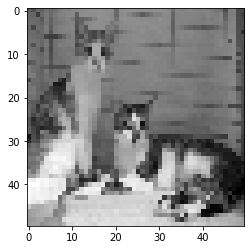


 90%|████████▉ | 2243/2494 [01:11<00:08, 28.73it/s]

tensor([0.1096, 0.8904])


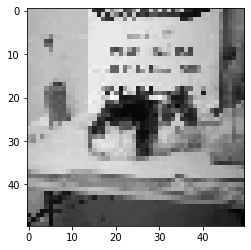


 90%|█████████ | 2250/2494 [01:11<00:07, 33.59it/s]

tensor([1.0000e+00, 2.4964e-06])


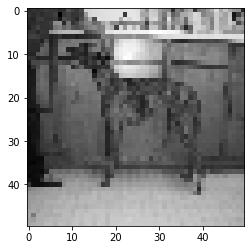


 90%|█████████ | 2255/2494 [01:11<00:06, 35.17it/s]

tensor([0.3009, 0.6991])


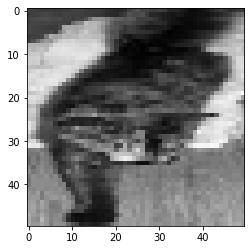

tensor([9.9916e-01, 8.3762e-04])


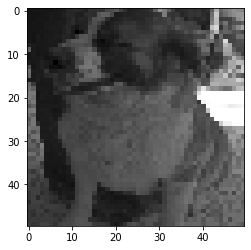


 91%|█████████ | 2260/2494 [01:11<00:07, 29.26it/s]

tensor([0.5468, 0.4532])


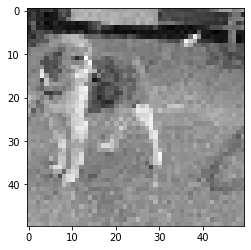


 91%|█████████ | 2270/2494 [01:11<00:06, 35.88it/s]

tensor([0.8000, 0.2000])


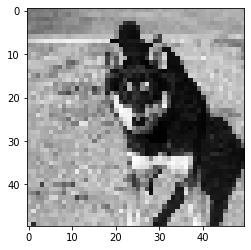

tensor([0.9732, 0.0268])


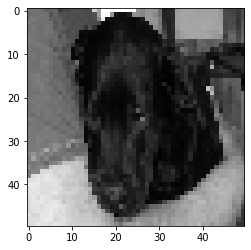


 91%|█████████ | 2275/2494 [01:12<00:07, 29.48it/s]

tensor([0.9194, 0.0806])


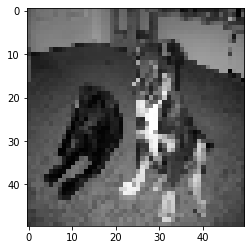

tensor([0.1143, 0.8857])


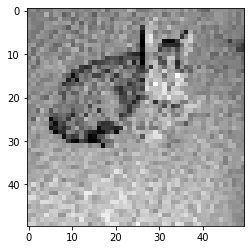


 91%|█████████▏| 2280/2494 [01:12<00:08, 26.46it/s]

tensor([0.1893, 0.8107])


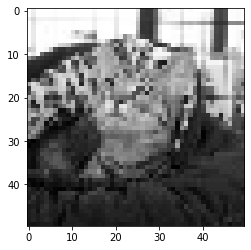


 92%|█████████▏| 2289/2494 [01:12<00:06, 31.34it/s]

tensor([0.0032, 0.9968])


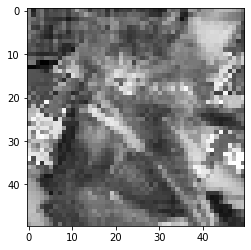


 92%|█████████▏| 2296/2494 [01:12<00:05, 36.10it/s]

tensor([0.1363, 0.8637])


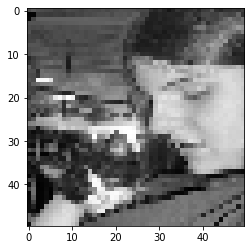


 92%|█████████▏| 2304/2494 [01:12<00:04, 41.30it/s]

tensor([0.9801, 0.0199])


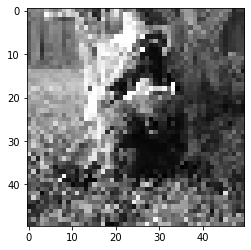


 93%|█████████▎| 2310/2494 [01:12<00:04, 43.10it/s]

tensor([0.9946, 0.0054])


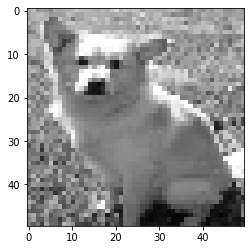

tensor([0.2044, 0.7956])


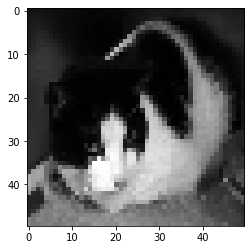


 93%|█████████▎| 2315/2494 [01:13<00:05, 32.01it/s]

tensor([0.5071, 0.4929])


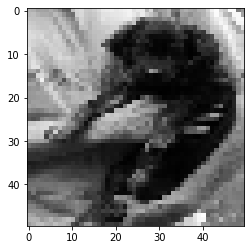


 93%|█████████▎| 2320/2494 [01:13<00:05, 33.09it/s]

tensor([0.9815, 0.0185])


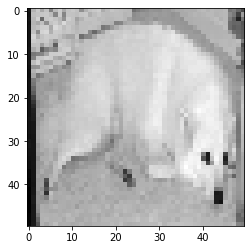


 93%|█████████▎| 2324/2494 [01:13<00:05, 31.96it/s]

tensor([0.9521, 0.0479])


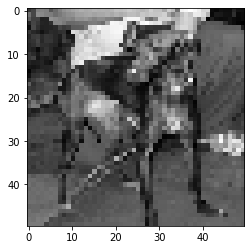

tensor([0.7346, 0.2654])


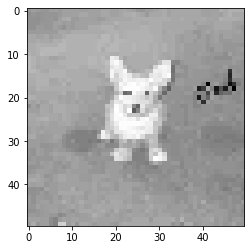


 93%|█████████▎| 2328/2494 [01:13<00:06, 24.72it/s]

tensor([0.0266, 0.9734])


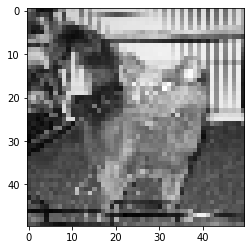


 94%|█████████▎| 2332/2494 [01:13<00:06, 26.49it/s]

tensor([9.9954e-01, 4.5579e-04])


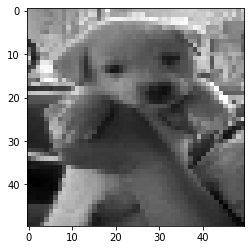

tensor([0.1684, 0.8316])


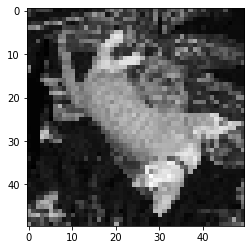


 94%|█████████▎| 2336/2494 [01:14<00:07, 21.13it/s]

tensor([9.9983e-01, 1.7422e-04])


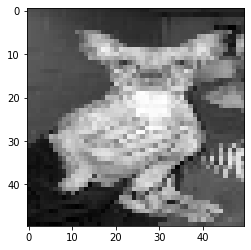


 94%|█████████▍| 2339/2494 [01:14<00:07, 22.00it/s]

tensor([9.9963e-01, 3.7003e-04])


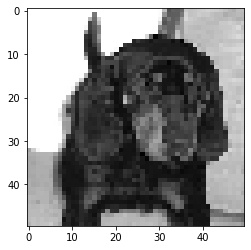


 94%|█████████▍| 2342/2494 [01:14<00:06, 22.52it/s]

tensor([0.4437, 0.5563])


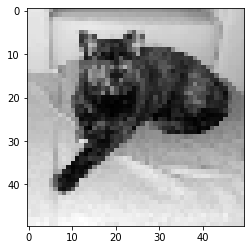


 94%|█████████▍| 2345/2494 [01:14<00:06, 23.23it/s]

tensor([7.4142e-05, 9.9993e-01])


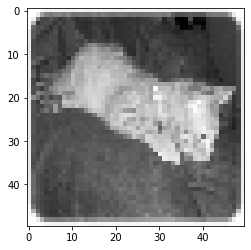


 94%|█████████▍| 2349/2494 [01:14<00:05, 25.45it/s]

tensor([0.0102, 0.9898])


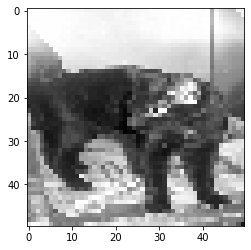


 94%|█████████▍| 2353/2494 [01:14<00:05, 27.24it/s]

tensor([0.0876, 0.9124])


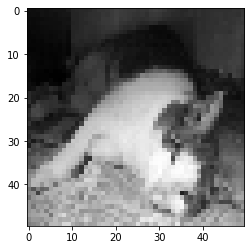


 94%|█████████▍| 2356/2494 [01:14<00:05, 26.36it/s]

tensor([0.0839, 0.9161])


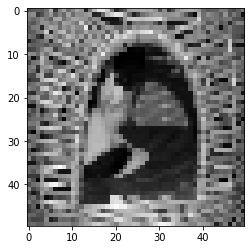


 95%|█████████▍| 2359/2494 [01:14<00:05, 25.87it/s]

tensor([0.9892, 0.0108])


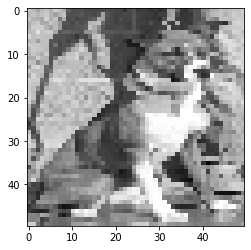


 95%|█████████▍| 2366/2494 [01:15<00:04, 30.76it/s]

tensor([0.6736, 0.3264])


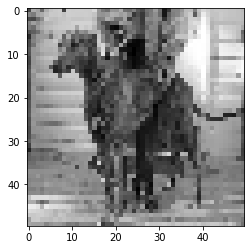


 95%|█████████▌| 2370/2494 [01:15<00:03, 31.30it/s]

tensor([0.5498, 0.4502])


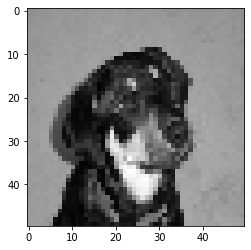


 95%|█████████▌| 2377/2494 [01:15<00:03, 34.25it/s]

tensor([0.6162, 0.3838])


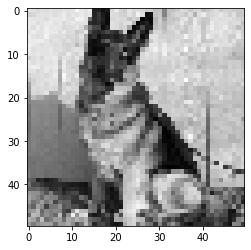


 95%|█████████▌| 2381/2494 [01:15<00:03, 33.86it/s]

tensor([0.0013, 0.9987])


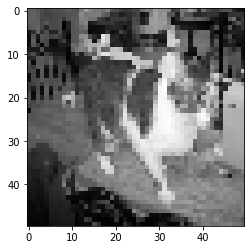


 96%|█████████▌| 2386/2494 [01:15<00:03, 35.61it/s]

tensor([0.0013, 0.9987])


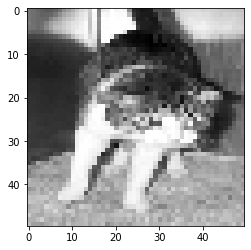

tensor([0.9278, 0.0722])


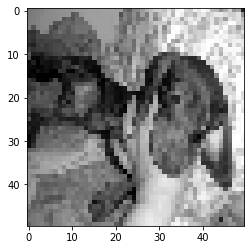


 96%|█████████▌| 2390/2494 [01:15<00:03, 26.70it/s]

tensor([0.3061, 0.6939])


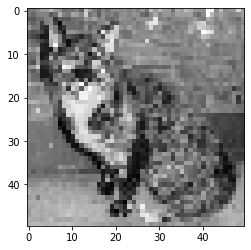


 96%|█████████▌| 2394/2494 [01:15<00:03, 28.31it/s]

tensor([0.5689, 0.4311])


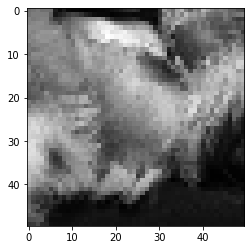

tensor([0.9398, 0.0602])


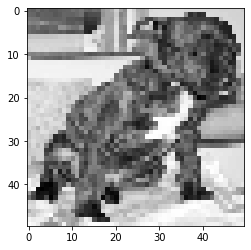


 96%|█████████▌| 2398/2494 [01:16<00:04, 23.60it/s]

tensor([0.9975, 0.0025])


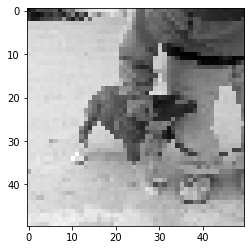


 96%|█████████▋| 2403/2494 [01:16<00:03, 27.04it/s]

tensor([0.8510, 0.1490])


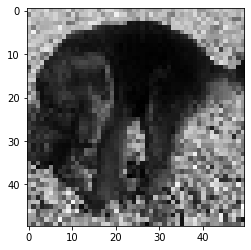

tensor([1.7453e-04, 9.9983e-01])


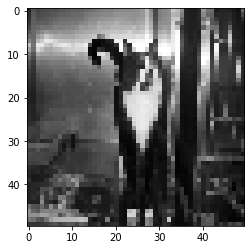


 97%|█████████▋| 2407/2494 [01:16<00:03, 22.95it/s]

tensor([0.9852, 0.0148])


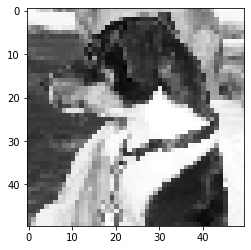


 97%|█████████▋| 2412/2494 [01:16<00:03, 24.96it/s]

tensor([0.0016, 0.9984])


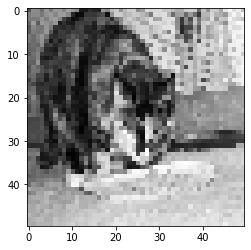


 97%|█████████▋| 2417/2494 [01:16<00:02, 28.23it/s]

tensor([0.0024, 0.9976])


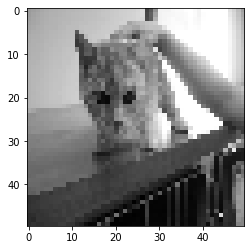


 97%|█████████▋| 2421/2494 [01:16<00:02, 29.44it/s]

tensor([0.9502, 0.0498])


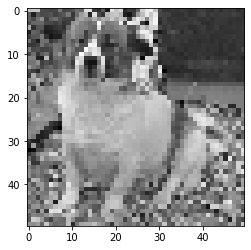


 97%|█████████▋| 2425/2494 [01:17<00:02, 30.39it/s]

tensor([0.4585, 0.5415])


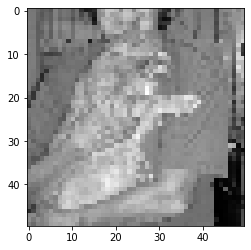


 98%|█████████▊| 2432/2494 [01:17<00:01, 35.26it/s]

tensor([0.2188, 0.7812])


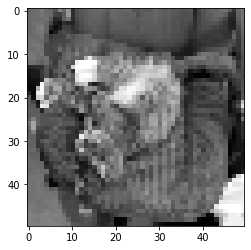


 98%|█████████▊| 2436/2494 [01:17<00:01, 34.41it/s]

tensor([0.0366, 0.9634])


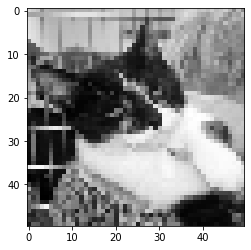

tensor([0.5567, 0.4433])


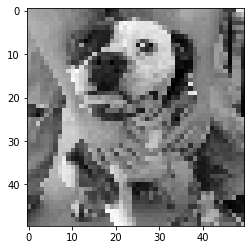


 98%|█████████▊| 2440/2494 [01:17<00:02, 26.31it/s]

tensor([0.0218, 0.9782])


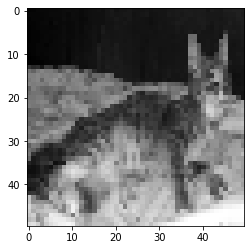

tensor([0.0304, 0.9696])


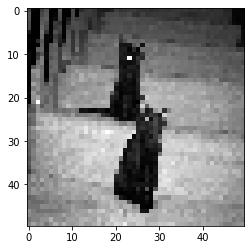


 98%|█████████▊| 2444/2494 [01:17<00:02, 22.49it/s]

tensor([0.0835, 0.9165])


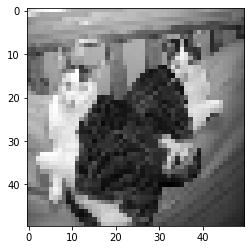


 98%|█████████▊| 2452/2494 [01:17<00:01, 27.80it/s]

tensor([0.4280, 0.5720])


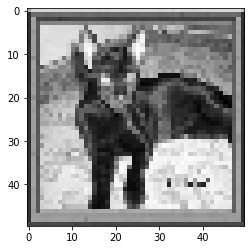


 98%|█████████▊| 2456/2494 [01:18<00:01, 26.98it/s]

tensor([0.5556, 0.4444])


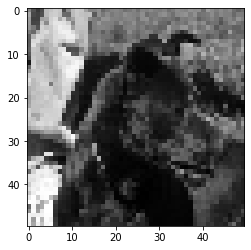

tensor([0.9666, 0.0334])


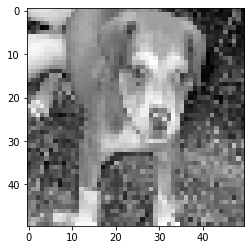


 99%|█████████▊| 2460/2494 [01:18<00:01, 22.74it/s]

tensor([0.6961, 0.3039])


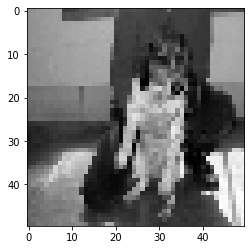

tensor([0.9166, 0.0834])


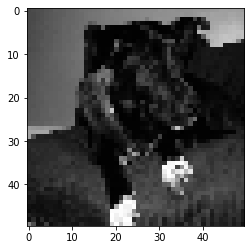


 99%|█████████▉| 2463/2494 [01:18<00:01, 18.19it/s]

tensor([9.9987e-01, 1.2998e-04])


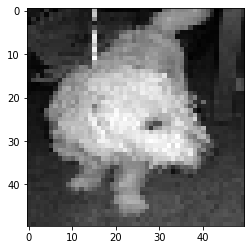


 99%|█████████▉| 2466/2494 [01:18<00:01, 19.61it/s]

tensor([0.0299, 0.9701])


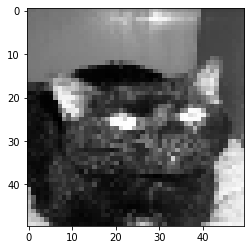


 99%|█████████▉| 2470/2494 [01:18<00:01, 22.13it/s]

tensor([0.0514, 0.9486])


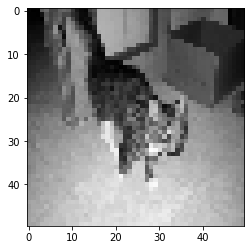

tensor([0.9385, 0.0615])


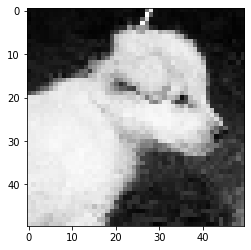


 99%|█████████▉| 2473/2494 [01:19<00:01, 18.05it/s]

tensor([0.8663, 0.1337])


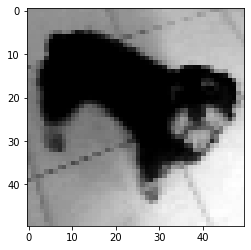


 99%|█████████▉| 2479/2494 [01:19<00:00, 22.20it/s]

tensor([0.2959, 0.7041])


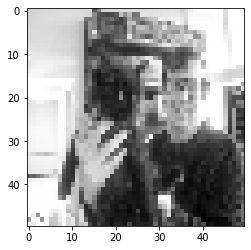

tensor([0.0514, 0.9486])


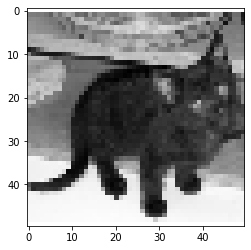


100%|█████████▉| 2482/2494 [01:19<00:00, 17.16it/s]

tensor([0.0042, 0.9958])


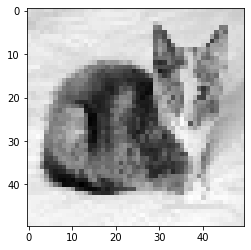

tensor([0.2870, 0.7130])


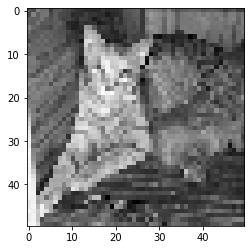


100%|█████████▉| 2485/2494 [01:19<00:00, 15.60it/s]

tensor([9.9996e-01, 4.1205e-05])


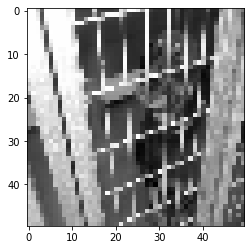

tensor([0.6510, 0.3490])


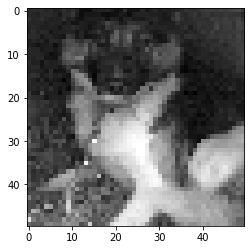


100%|██████████| 2494/2494 [01:19<00:00, 31.21it/s]

Accuracy: 0.765


In [75]:
test(net)

In [17]:
BATCH_SIZE = 100

In [73]:
def fwd_pass(X, y, train=False):

    if train:
        net.zero_grad()
    outputs = net(X)
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimiser.step()

    return acc, loss

In [88]:
path = 'Downloads/ZDwnJMyv8lY.jpg'

In [89]:
img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (50, 50))

In [90]:
img

array([[222, 255, 255, ..., 255, 255, 255],
       [222, 255, 255, ..., 255, 255, 255],
       [222, 255, 255, ..., 255, 255, 255],
       ...,
       [222, 255, 255, ..., 255, 255, 255],
       [222, 255, 255, ..., 255, 255, 255],
       [222, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [91]:
img = img/255

In [92]:
datax = torch.Tensor(img).view(-1,50,50)

In [93]:
datax

tensor([[[0.8706, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.8706, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.8706, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.8706, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.8706, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.8706, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]])

In [94]:
net(datax.view(-1,1,50,50))

tensor([[0.0125, 0.9875]], grad_fn=<SoftmaxBackward>)

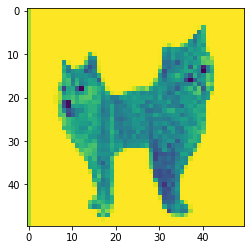

In [95]:
plt.imshow(img,)

In [98]:
torch.save(net.state_dict(), 'Neural')